# 2nd CMI-PB Prediction Challenge
### Team Advisor: Barry Grant, Jason Hsiao
### Team member: Peng Cheng, Javier Garcia, Brian Qian, Weikang Guan

In [1]:
import os
import csv
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler,Normalizer,RobustScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression,LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.exceptions import ConvergenceWarning
from joblib import dump, load
from math import sqrt

warnings.filterwarnings("ignore", category=ConvergenceWarning)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

if not os.path.exists('training_result'):
    os.makedirs('training_result')

if not os.path.exists('prediction_result'):
    os.makedirs('prediction_result')

### Step 1: Data Preparation

In [2]:
## Load data into dataframes
df_2020_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_specimen.tsv", sep='\t')
df_2020_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_subject.tsv", sep='\t')
df_2020_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_plasma_ab_titer.tsv", sep='\t')
df_2020_cell_freq = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_pbmc_cell_frequency.tsv", sep='\t')
df_2020_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_pbmc_gene_expression.tsv", sep='\t')
df_2020_cytokine = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_plasma_cytokine_concentration.tsv", sep='\t')

df_2021_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_specimen.tsv", sep='\t')
df_2021_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_subject.tsv", sep='\t')
df_2021_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_plasma_ab_titer.tsv", sep='\t')
df_2021_cell_freq = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_pbmc_cell_frequency.tsv", sep='\t')
df_2021_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_pbmc_gene_expression.tsv", sep='\t')
df_2021_cytokine = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_plasma_cytokine_concentration.tsv", sep='\t')

df_2022_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_specimen.tsv", sep='\t')
df_2022_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_subject.tsv", sep='\t')
df_2022_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_plasma_ab_titer.tsv", sep='\t')
df_2022_cell_freq = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_pbmc_cell_frequency.tsv", sep='\t')
df_2022_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_pbmc_gene_expression.tsv", sep='\t')
df_2022_cytokine = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_plasma_cytokine_concentration.tsv", sep='\t')

In [3]:
def clean_df_subject(df):
    ## Get age column
    df['Age'] = pd.to_numeric(df['date_of_boost'].str[:4]) - pd.to_numeric(df['year_of_birth'].str[:4])
        
    ##use OneHotEncoder for infancy_vac', 'biological_sex', 'ethnicity' and 'race' columns
    columns_to_encode = ['infancy_vac', 'biological_sex', 'ethnicity', 'race']
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    df_encoded = pd.DataFrame(encoder.fit_transform(df[columns_to_encode]), columns=encoder.get_feature_names_out(columns_to_encode))
    result_df = pd.concat([df, df_encoded], axis=1)
    result_df.drop(columns=columns_to_encode, inplace=True)
    result_df.drop(['year_of_birth','date_of_boost',"dataset"], axis=1, inplace=True)
    return result_df

def clean_df_specimen(df):
    # extract row with 0 or 14 in the "planned_day_relative_to_boost" column
    df = df[(df['planned_day_relative_to_boost'] == 0) | 
            (df['planned_day_relative_to_boost'] == 1) |
            (df['planned_day_relative_to_boost'] == 3) |
            (df['planned_day_relative_to_boost'] == 14)]
    result_df = df[['specimen_id', 'subject_id', 'actual_day_relative_to_boost', 'planned_day_relative_to_boost']]
    
    #remove subjects that have either only 0 or only 14 in the "planned_day_relative_to_boost" column,
    result_df = result_df.groupby('subject_id').filter(lambda x: (0 in x['planned_day_relative_to_boost'].values) and\
                                                       (1 in x['planned_day_relative_to_boost'].values) and\
                                                       (3 in x['planned_day_relative_to_boost'].values) and\
                                                       (14 in x['planned_day_relative_to_boost'].values))
    result_df = create_date_diff_col(result_df,'date_diff_D0',0)
    result_df = create_date_diff_col(result_df,'date_diff_D1',1)
    result_df = create_date_diff_col(result_df,'date_diff_D3',3)
    result_df = create_date_diff_col(result_df,'date_diff_D14',14)
    result_df = result_df.drop("actual_day_relative_to_boost", axis=1)
    return result_df

def clean_df_titer(df):
    # Create a new column name list based on isotype and antigen
    new_columns = [f"{isotype}-{antigen}" for isotype in df['isotype'].unique() for antigen in df['antigen'].unique()]
    
    # Initialize an empty list to collect rows
    rows = []
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        specimen_id = row['specimen_id']
        isotype = row['isotype']
        antigen = row['antigen']
        MFI_normalised = row['MFI_normalised']
        column_name = f"{isotype}-{antigen}"
        
        # Check if there's already a row for the specimen
        existing_row = next((r for r in rows if r['specimen_id'] == specimen_id), None)
        if existing_row:
            existing_row[column_name] = MFI_normalised
        else:
            # Create a new row with all columns initialized to zero
            new_row = {col: 0 for col in new_columns}
            new_row['specimen_id'] = specimen_id
            new_row[column_name] = MFI_normalised
            rows.append(new_row)
    
    # Convert list of rows to DataFrame
    result_df = pd.DataFrame(rows)
    result_df['specimen_id'] = result_df['specimen_id'].astype(int)
    
    return result_df

def clean_df_cell_freq(df):
    result_df = df.pivot_table(index=['specimen_id'], columns=['cell_type_name'], values= 'percent_live_cell').reset_index()
    return result_df

def clean_df_gene(df):
    result_df = df.pivot_table(index=['specimen_id'], columns=['versioned_ensembl_gene_id'], values= 'tpm').reset_index()
    result_df.columns = [''.join(col).strip() for col in result_df.columns.values]
    return result_df

def clean_df_cytokine(df):
    result_df = df.pivot_table(index=['specimen_id'], columns=['protein_id'], values= 'protein_expression').reset_index()
    return result_df

def drop_nan_col(df,cols):
    # Filter out columns not named "Monocytes"
    non_monocytes_columns = [col for col in df.columns if col != cols]
    
    # Check if these columns contain NaN values
    columns_with_nan = df[non_monocytes_columns].columns[df[non_monocytes_columns].isna().any()].tolist()
    
    # Drop columns containing NaN values
    result_df = df.drop(columns=columns_with_nan)
    return result_df

def create_date_diff_col(df,col_name,date_num):
    df_copy = df.copy()
    # Create a new column 'date_diff_D0' based on the difference between planned and actual days relative to boost
    df_copy[col_name] = df_copy['actual_day_relative_to_boost'] - df_copy['planned_day_relative_to_boost']
    
    # Filter rows where 'planned_day_relative_to_boost' is date_num
    mask = df_copy['planned_day_relative_to_boost'] == date_num
    
    # Update 'date_diff_D0' to NaN where 'planned_day_relative_to_boost' is not 0
    df_copy.loc[~mask, col_name] = pd.NA

    if col_name in df_copy.columns:
    # Use groupby and transform to fill NaNs in 'date_diff_D0' within each subject_id group
        df_copy[col_name] = df_copy.groupby('subject_id')[col_name].transform(lambda x: x.ffill().bfill())
    return df_copy

def create_target_col(df, col_name, date_num):
    # Filter the DataFrame to get col_name values for planned_day_relative_to_boost = date_num
    df_date = df[df['planned_day_relative_to_boost'] == date_num][['subject_id', col_name]]
    
    # Create a dictionary from the filtered DataFrame
    id_to_igg = pd.Series(df_date[col_name].values, index=df_date['subject_id']).to_dict()
    
    # Map this dictionary to a new column in a separate DataFrame
    new_col_name = col_name + "_D" + str(date_num)
    new_fc_col_name = new_col_name + "_FC"
    new_df = pd.DataFrame()
    new_df[new_col_name] = df['subject_id'].map(id_to_igg)
    new_df[new_fc_col_name] = np.log2(new_df[new_col_name] / df[col_name])

    # Concatenate the new DataFrame with the original DataFrame
    df = pd.concat([df, new_df], axis=1)
    return df

In [4]:
df_specimen = pd.concat([clean_df_specimen(df_2020_specimen),clean_df_specimen(df_2021_specimen),],ignore_index=True).fillna(0.0)
df_subject = pd.concat([clean_df_subject(df_2020_subject),clean_df_subject(df_2021_subject),],ignore_index=True).fillna(0.0)
df_titer = pd.concat([clean_df_titer(df_2020_titer),clean_df_titer(df_2021_titer),],ignore_index=True)
df_cell_freq = pd.concat([clean_df_cell_freq(df_2020_cell_freq),clean_df_cell_freq(df_2021_cell_freq),],ignore_index=True)
df_cell_freq = drop_nan_col(df_cell_freq,"Monocytes")
df_gene = pd.concat([clean_df_gene(df_2020_gene),clean_df_gene(df_2021_gene),],ignore_index=True)
df_cytokine = pd.concat([clean_df_cytokine(df_2020_cytokine),clean_df_cytokine(df_2021_cytokine),],ignore_index=True)
df_cytokine = drop_nan_col(df_cytokine,"P10147")

df_train = df_specimen.merge(df_subject, on='subject_id', how='left')
df_train = df_train.merge(df_titer, on='specimen_id', how='left').fillna(1.0)
df_train = df_train.merge(df_cell_freq, on='specimen_id', how='left')
df_train = df_train.merge(df_gene, on='specimen_id', how='left')
df_train = df_train.merge(df_cytokine, on='specimen_id', how='left')

df_pred = clean_df_specimen(df_2022_specimen).merge(clean_df_subject(df_2022_subject), on='subject_id', how='left')
df_pred = df_pred.merge(clean_df_titer(df_2022_titer), on='specimen_id', how='left').fillna(1.0)
df_pred = df_pred.merge(clean_df_cell_freq(df_2022_cell_freq), on='specimen_id', how='left')
df_pred = df_pred.merge(clean_df_gene(df_2022_gene), on='specimen_id', how='left')
df_pred = df_pred.merge(clean_df_cytokine(df_2022_cytokine), on='specimen_id', how='left')

common_columns = df_train.columns.intersection(df_pred.columns)
df_train = df_train.loc[:, common_columns]
df_pred = df_pred.loc[:, common_columns]

df_train = create_target_col(df_train,"IgG-PT",14)
df_train = create_target_col(df_train,"Monocytes",1)
df_train = create_target_col(df_train,"ENSG00000277632.1",3)

df_train = df_train[df_train['planned_day_relative_to_boost'] == 0]
df_train = df_train.drop(['subject_id','specimen_id','planned_day_relative_to_boost','race_Unknown or Not Reported'], axis=1)

# Rename the columns
df_train = df_train.rename(columns={
    'IgG-PT_D14': 'task11',
    'IgG-PT_D14_FC': 'task12',
    'Monocytes_D1': 'task21',
    'Monocytes_D1_FC': 'task22',
    'ENSG00000277632.1_D3': 'task31',
    'ENSG00000277632.1_D3_FC': 'task32'
})

df_train_task11 = df_train.drop(columns=['date_diff_D1','date_diff_D3','task12','task21','task22','task31','task32']).dropna(subset=['task11'])
df_train_task12 = df_train.drop(columns=['date_diff_D1','date_diff_D3','task11','task21','task22','task31','task32']).dropna(subset=['task12'])
df_train_task21 = df_train.drop(columns=['date_diff_D3','date_diff_D14','task11','task12','task22','task31','task32']).dropna(subset=['task21'])
df_train_task22 = df_train.drop(columns=['date_diff_D3','date_diff_D14','task11','task12','task21','task31','task32']).dropna(subset=['task22'])
df_train_task31 = df_train.drop(columns=['date_diff_D1','date_diff_D14','task11','task12','task21','task22','task32']).dropna(subset=['task31'])
df_train_task32 = df_train.drop(columns=['date_diff_D1','date_diff_D14','task11','task12','task21','task22','task31']).dropna(subset=['task32'])

df_train

,date_diff_D0,date_diff_D1,date_diff_D3,date_diff_D14,Age,infancy_vac_wP,biological_sex_Male,ethnicity_Not Hispanic or Latino,race_More Than One Race,race_White,...,Q07325,Q14116,Q99616,Q99731,task11,task12,task21,task22,task31,task32
0,-3.0,0.0,0.0,-3.0,30,1.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,10.874112,1.540948,NaN,NaN,46.410,0.239062
7,-3.0,0.0,0.0,0.0,33,1.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,7.041547,2.683163,NaN,NaN,26.204,0.172494
11,-7.0,0.0,0.0,0.0,28,1.0,1.0,1.0,0.0,0.0,...,6.69559,8.45333,10.20229,11.48567,7.896541,1.947941,7.211965,0.393366,13.353,-0.268462
15,-5.0,0.0,0.0,0.0,25,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,5.327203,0.488136,NaN,NaN,20.618,-0.502163
19,-6.0,0.0,0.0,0.0,28,1.0,0.0,1.0,0.0,1.0,...,6.99032,9.10157,12.90550,9.68797,9.128886,5.419294,41.380502,0.860359,19.606,-0.220520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,0.0,0.0,0.0,19,0.0,0.0,0.0,0.0,1.0,...,71.72207,135.83942,274.72479,79.36819,3.350333,4.221438,33.000000,-0.299014,26.316,0.154588
364,0.0,0.0,0.0,0.0,23,0.0,0.0,1.0,1.0,0.0,...,75.27139,267.16750,234.91394,119.29151,5.722838,1.527971,15.000000,-0.119909,32.281,0.455877
368,0.0,0.0,0.0,0.0,20,0.0,1.0,1.0,0.0,0.0,...,40.04879,197.46171,196.59574,118.16835,8.813747,0.730327,39.500000,0.592286,18.308,-0.537758
372,0.0,0.0,0.0,0.0,21,0.0,0.0,0.0,0.0,0.0,...,49.30556,258.29362,499.46462,124.94525,9.567161,1.288160,23.500000,0.441889,25.533,-0.154036


In [5]:
df_pred = df_pred[df_pred['planned_day_relative_to_boost'] == 0].sort_values(by='subject_id')
df_pred = df_pred.drop(['subject_id','specimen_id','planned_day_relative_to_boost','race_Unknown or Not Reported'], axis=1)

df_pred_task11 = df_pred.drop(columns=['date_diff_D1','date_diff_D3'])
df_pred_task12 = df_pred.drop(columns=['date_diff_D1','date_diff_D3'])
df_pred_task21 = df_pred.drop(columns=['date_diff_D3','date_diff_D14'])
df_pred_task22 = df_pred.drop(columns=['date_diff_D3','date_diff_D14'])
df_pred_task31 = df_pred.drop(columns=['date_diff_D1','date_diff_D14'])
df_pred_task32 = df_pred.drop(columns=['date_diff_D1','date_diff_D14'])

df_pred

,date_diff_D0,date_diff_D1,date_diff_D3,date_diff_D14,Age,infancy_vac_wP,biological_sex_Male,ethnicity_Not Hispanic or Latino,race_More Than One Race,race_White,...,P39900,P48061,P50591,P51671,P80075,P80098,Q07325,Q14116,Q99616,Q99731
0,0.0,0.0,0.0,0.0,35,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,28,1.0,0.0,1.0,0.0,1.0,...,143.47070,172.20759,304.99289,238.03701,44.49960,1.40228,44.92446,191.77453,352.18214,75.39903
8,0.0,0.0,0.0,0.0,22,0.0,0.0,0.0,0.0,0.0,...,262.05862,157.49216,329.04351,198.04208,37.61698,1.26368,37.66179,171.94619,342.89254,71.29416
12,0.0,0.0,0.0,1.0,20,0.0,0.0,1.0,0.0,1.0,...,142.07892,170.13930,396.97901,186.09350,15.51482,2.27681,44.18109,275.30582,315.83084,80.05259
16,0.0,0.0,0.0,0.0,18,0.0,1.0,1.0,0.0,1.0,...,171.23029,128.86701,333.97388,208.10257,21.34345,1.36792,40.90259,131.66715,350.36360,98.05125
20,0.0,0.0,0.0,0.0,18,0.0,1.0,1.0,0.0,1.0,...,253.74390,131.52988,324.45175,263.92302,28.19689,2.00589,36.18402,201.80010,280.87910,202.01210
24,0.0,0.0,0.0,0.0,27,1.0,0.0,1.0,0.0,1.0,...,101.85431,198.19972,324.75355,178.13338,38.54503,3.01973,36.62592,302.96866,224.31955,135.45000
28,0.0,0.0,0.0,0.0,32,1.0,0.0,1.0,0.0,0.0,...,147.98410,152.25096,507.91511,326.82716,53.43469,2.69456,57.34962,277.70094,771.27698,161.54631
32,0.0,0.0,0.0,0.0,27,1.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,0.0,0.0,0.0,0.0,25,0.0,0.0,1.0,0.0,1.0,...,203.07800,203.37855,271.69315,279.30396,33.66228,1.65574,75.62800,175.08158,505.25834,95.76064


### Step2: Model Training

In [6]:
def find_best_scaler(X, y, task_name, model=None):
    if model is None:
        model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
        
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectFromModel(model)),
        ('regressor', model)  
    ])
    
    param_grid = {
        'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()],
        'feature_selector__estimator': [model],
        'regressor__alpha': [0.001, 0.01, 0.1] 
    }
    
    grid_search = GridSearchCV(pipe, param_grid, cv=3)
    grid_search.fit(X, y)
    
    best_scaler = grid_search.best_params_['scaler']
    print('Best scaler: ' + str(best_scaler.__class__.__name__))
    
    os.makedirs(f'training_result', exist_ok=True)
    with open(f'training_result/{task_name}_best_scaler.txt', 'w') as file:
        file.write(str(best_scaler.__class__.__name__))
    
    return best_scaler
    
def split_scale_select_features(df_train_task, task_name, threshold=0):
    X = df_train_task.drop(columns=[task_name])
    y = df_train_task[task_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = find_best_scaler(X_train, y_train, task_name)
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    coefficients = np.abs(lasso.coef_)  # Use absolute value to assess importance
    
    # Select features where the coefficient magnitude is greater than the threshold
    selected_features = X_train_scaled.columns[coefficients > threshold]
    X_train_selected = X_train_scaled[selected_features]
    X_test_selected = X_test_scaled[selected_features]
    
    # Get the indices of these selected features for plotting
    indices = np.where(coefficients > threshold)[0]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(selected_features)), coefficients[indices], align='center')
    plt.yticks(range(len(selected_features)), selected_features)
    plt.xlabel('Lasso Coefficient Magnitude')
    plt.ylabel('Feature')
    plt.title(f'{task_name} Top Feature Selected')
    plt.show()
    
    # Creating DataFrame to save to CSV
    pd.DataFrame({
        'Selected Features': selected_features,
        'Coefficient Magnitude': coefficients[indices]
    }).to_csv(f'training_result/{task_name}_Feature_Selected.csv', index=False)
    
    return X_train_selected, X_test_selected, y_train, y_test

def train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)
    return grid_search.best_estimator_, mse, mae, r2, explained_var

def visualize_model_performance(results_df,task_name):
    plt.figure(figsize=(12, 6))
    results_df['R-squared'].plot(kind='bar', color='navy')
    plt.title(task_name+' Model R-squared Comparison')
    plt.ylabel('R-squared')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()

def train_best_model(df_train_task, task_name):
    X_train, X_test, y_train, y_test = split_scale_select_features(df_train_task, task_name)
    models = {
        'Random Forest': (RandomForestRegressor(), {
            'n_estimators': [20,30,40,50,100,300,500],
            'max_depth': [5,10,20,30],
            'min_samples_split': [2,5,10,15],
            'min_samples_leaf': [1,2,3,4]
        }),
        'SVR': (SVR(), {
            'C': [1, 5, 10,20],
            'kernel': ['linear', 'rbf']
        }),
        'Gradient Boosting': (GradientBoostingRegressor(), {
            'n_estimators': [20,30,50,75,100,200],
            'learning_rate': [0.001,0.01,0.1,1],
            'max_depth': [2,3,4,5],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [1,2,3]
        }),
        'Lasso': (Lasso(), {
            'alpha': [0.001,0.01,0.1,1,10]
        }),
        'Ridge': (Ridge(), {
            'alpha': [1, 10, 100]
        }),
        'ElasticNet': (ElasticNet(), {
            'alpha': [0.001,0.01,0.1,1,10],
            'l1_ratio': [0.1,0.5,0.8]
        }),
        'Decision Tree': (DecisionTreeRegressor(), {
            'max_depth': [None,5,10,20,50,100],
            'min_samples_split': [2,5,10,20],
            'min_samples_leaf': [1,5,10]
        }),
        'KNN': (KNeighborsRegressor(), {
            'n_neighbors': [3,5,7],
            'weights': ['uniform', 'distance']
        }),
        'Linear Regression': (LinearRegression(), {})
    }
    
    results = []
    for model_name, (model, params) in models.items():
        best_model, mse, mae, r2, explained_var = train_and_evaluate_model(model, params, X_train, X_test, y_train, y_test)
        results.append([model_name, mse, mae, r2, explained_var])

    # Save results to DataFrame and then to CSV
    df = pd.DataFrame(results, columns=['Model', 'MSE', 'MAE', 'R-squared', 'Explained Variance'])
    df.set_index('Model', inplace=True)
    df.to_csv(f"training_result/{task_name}_model_evaluation.csv")
    print("Saved model evaluation metrics to CSV.")
    visualize_model_performance(df,task_name)
    print(df)
    
    # Find and save the best model
    best_model_name = df['R-squared'].idxmax()
    best_model = models[best_model_name][0]
    best_model.fit(X_train, y_train)
    dump(best_model, f"training_result/{task_name}_best_model.joblib")
    print(f"Best model ({best_model_name}) saved.")
    
    return None

Best scaler: MinMaxScaler


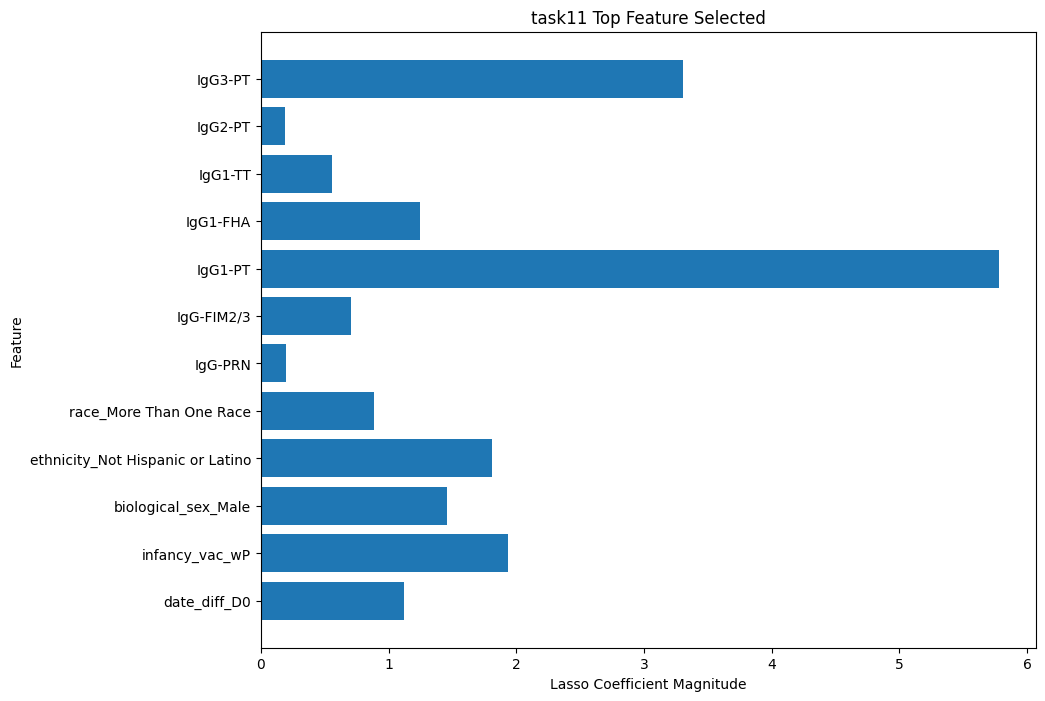

Saved model evaluation metrics to CSV.


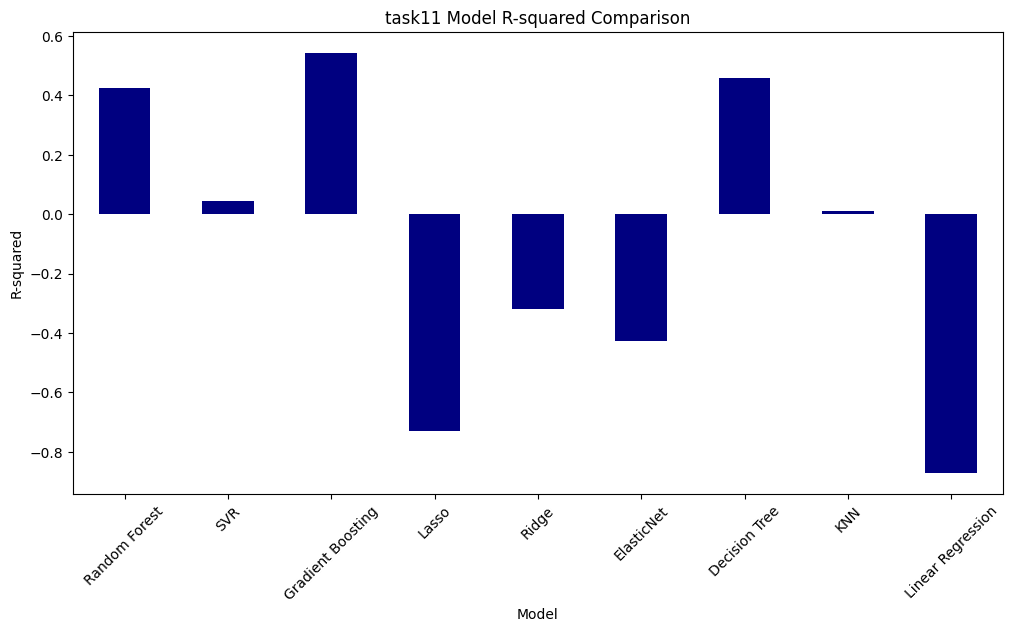

                         MSE       MAE  R-squared  Explained Variance
Model                                                                
Random Forest      12.172518  2.928528   0.423672            0.427095
SVR                20.189491  3.525301   0.044095            0.052255
Gradient Boosting   9.651349  2.393845   0.543041            0.543198
Lasso              36.576348  4.719498  -0.731768           -0.721784
Ridge              27.891055  4.221368  -0.320549           -0.303423
ElasticNet         30.174487  4.390935  -0.428661           -0.413901
Decision Tree      11.419251  2.711929   0.459336            0.471564
KNN                20.914268  3.477973   0.009779            0.034475
Linear Regression  39.525513  4.765549  -0.871401           -0.864917
Best model (Gradient Boosting) saved.


In [7]:
train_best_model(drop_nan_col(df_train_task11,'task11'), 'task11')

Best scaler: Normalizer


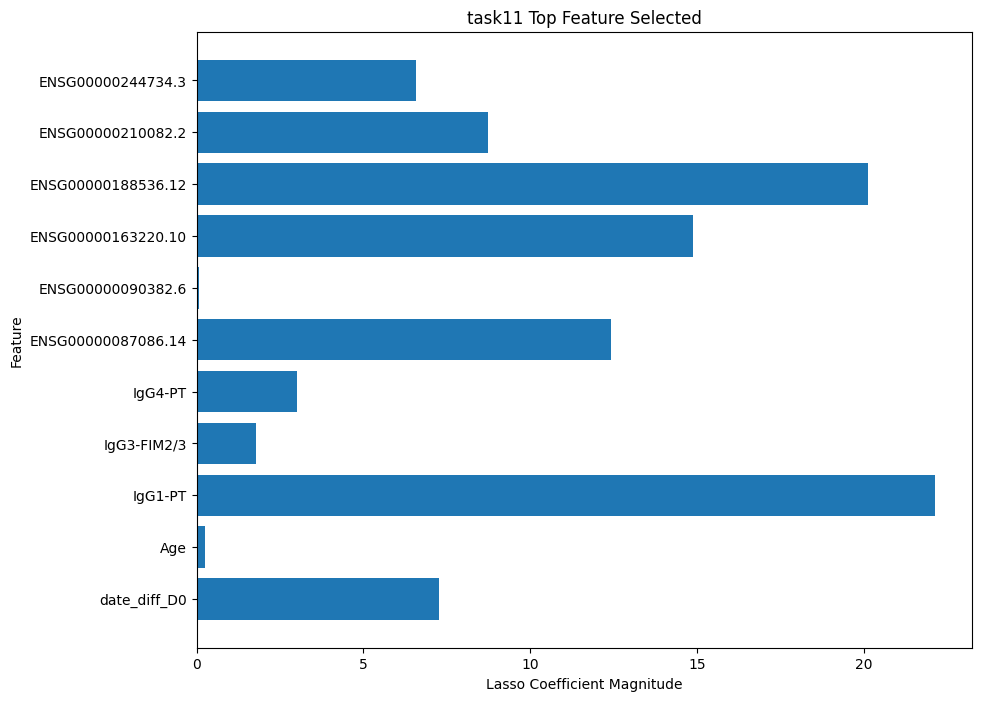

Saved model evaluation metrics to CSV.


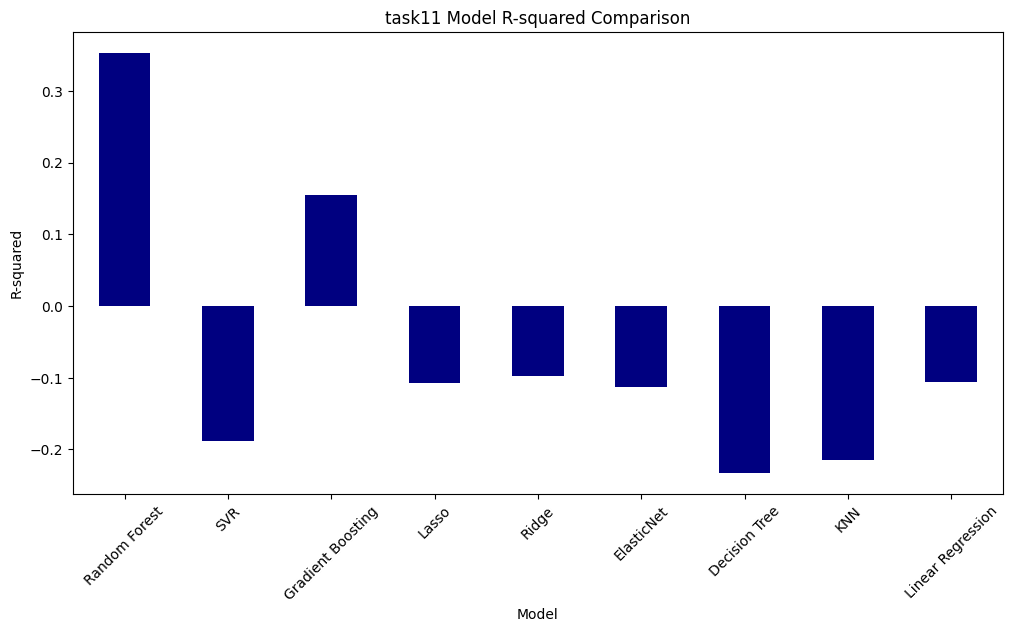

                         MSE       MAE  R-squared  Explained Variance
Model                                                                
Random Forest      13.667777  3.068191   0.352876            0.352877
SVR                25.101010  4.037660  -0.188449           -0.171555
Gradient Boosting  17.853320  3.607301   0.154705            0.160638
Lasso              23.387903  4.022412  -0.107339           -0.100862
Ridge              23.172239  4.165631  -0.097128           -0.076094
ElasticNet         23.502139  4.165672  -0.112748           -0.095167
Decision Tree      26.036842  4.022820  -0.232758           -0.232039
KNN                25.648860  3.951881  -0.214388           -0.198363
Linear Regression  23.369987  4.020929  -0.106491           -0.100202
Best model (Random Forest) saved.


In [8]:
train_best_model(df_train_task11.fillna(0.0), 'task11')

Best scaler: Normalizer


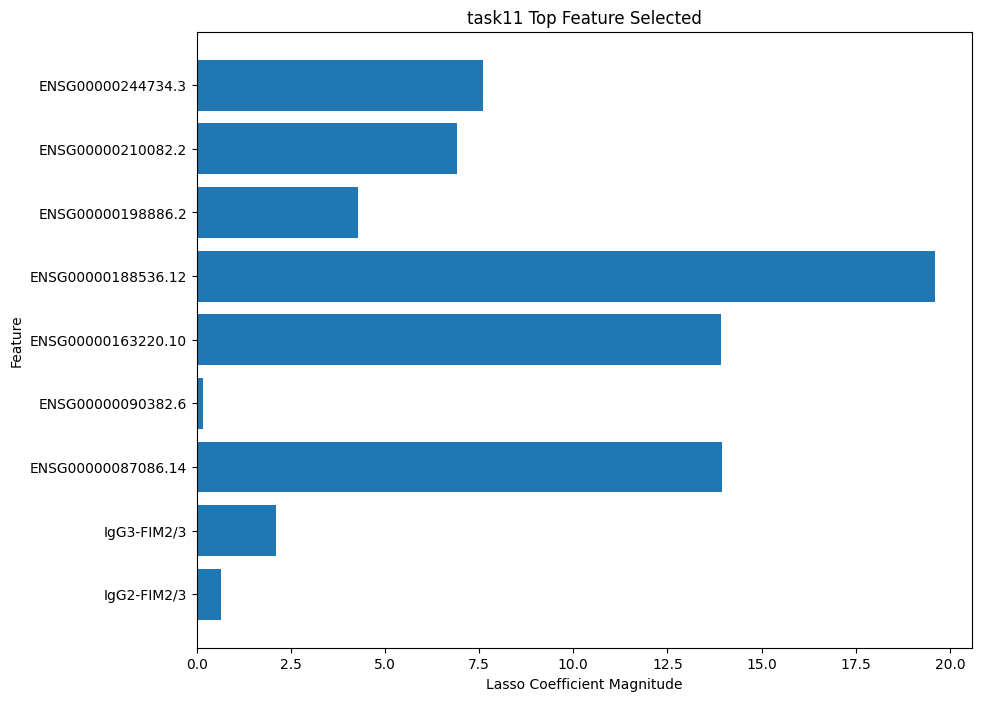

Saved model evaluation metrics to CSV.


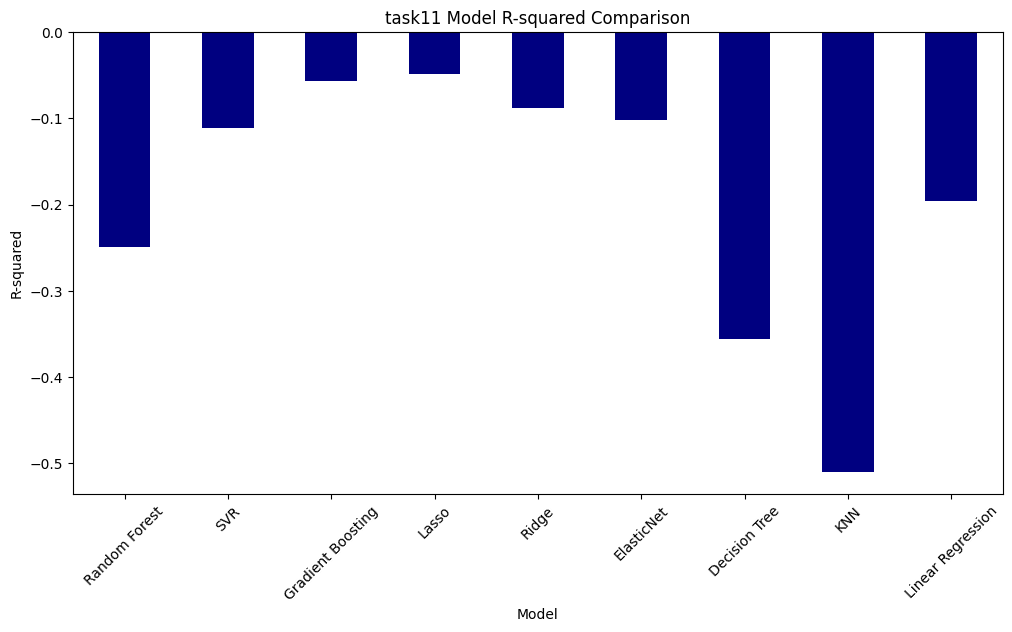

                         MSE       MAE  R-squared  Explained Variance
Model                                                                
Random Forest      26.391850  4.088641  -0.249566           -0.244084
SVR                23.463844  3.978899  -0.110935           -0.106781
Gradient Boosting  22.313979  4.093057  -0.056493           -0.028930
Lasso              22.145394  4.152597  -0.048511            0.000000
Ridge              22.991778  4.152079  -0.088584           -0.064799
ElasticNet         23.281415  4.146180  -0.102297           -0.081052
Decision Tree      28.626205  4.116392  -0.355356           -0.354813
KNN                31.888715  4.343479  -0.509824           -0.479201
Linear Regression  25.253579  4.225384  -0.195673           -0.185526
Best model (Lasso) saved.


In [9]:
train_best_model(df_train_task11.fillna(1.0), 'task11')

Best scaler: Normalizer


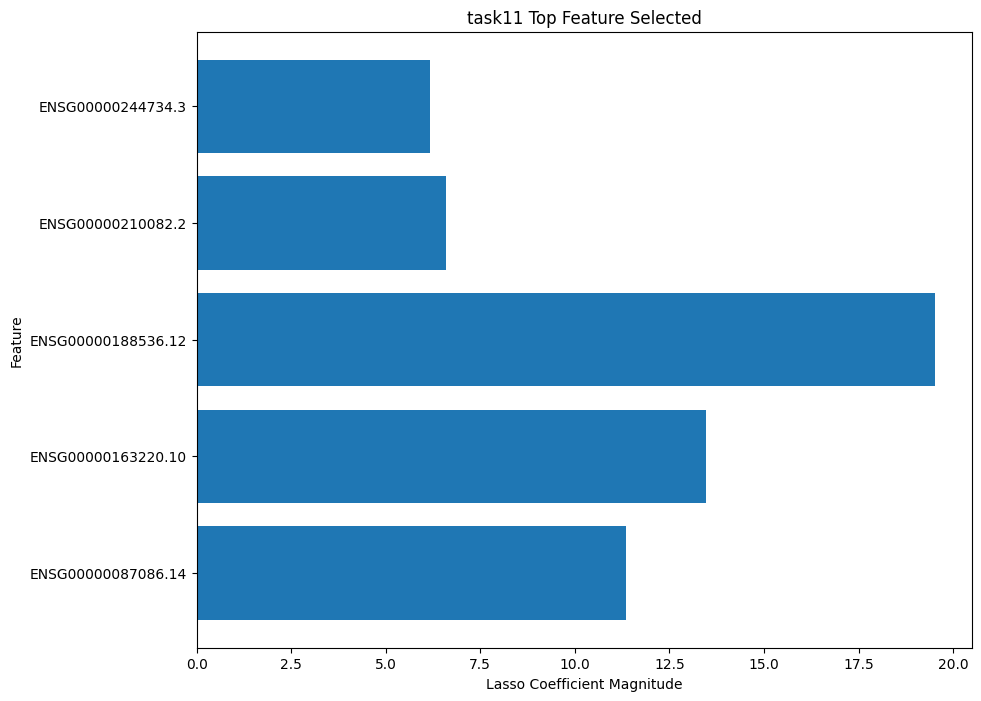

Saved model evaluation metrics to CSV.


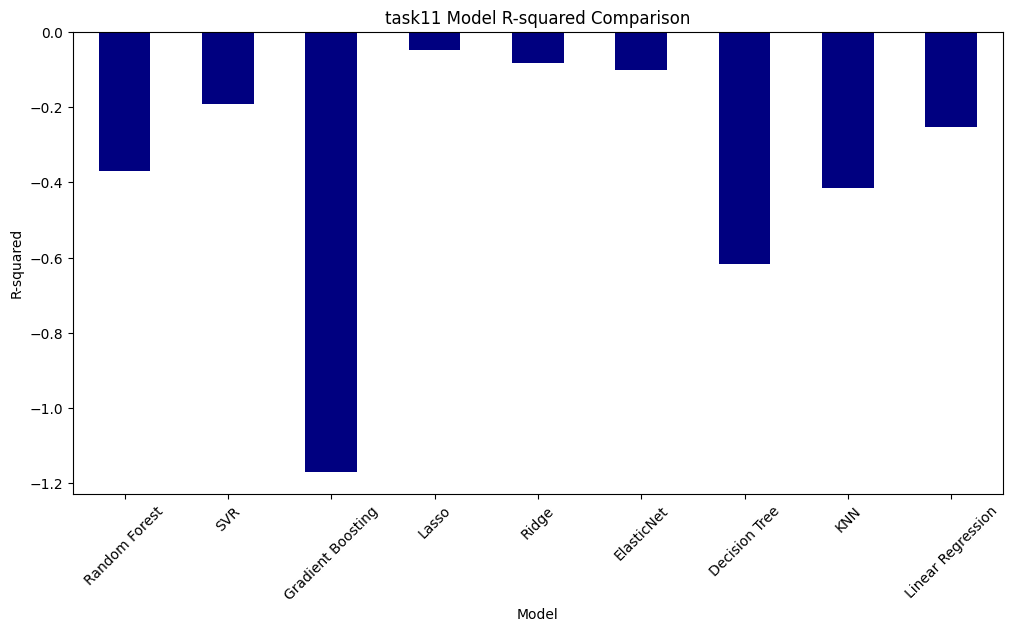

                         MSE       MAE  R-squared  Explained Variance
Model                                                                
Random Forest      28.929073  4.241315  -0.369695           -0.366058
SVR                25.158507  4.071701  -0.191172           -0.182827
Gradient Boosting  45.828159  5.738706  -1.169811           -1.138831
Lasso              22.145394  4.152597  -0.048511            0.000000
Ridge              22.889474  4.170960  -0.083740           -0.060968
ElasticNet         23.251668  4.174264  -0.100889           -0.080685
Decision Tree      34.130235  4.432985  -0.615953           -0.600919
KNN                29.877544  4.306831  -0.414602           -0.411699
Linear Regression  26.481224  4.367576  -0.253798           -0.240633
Best model (Lasso) saved.


In [10]:
train_best_model(df_train_task11.fillna(df_train_task11.median()), 'task11')

Best scaler: Normalizer


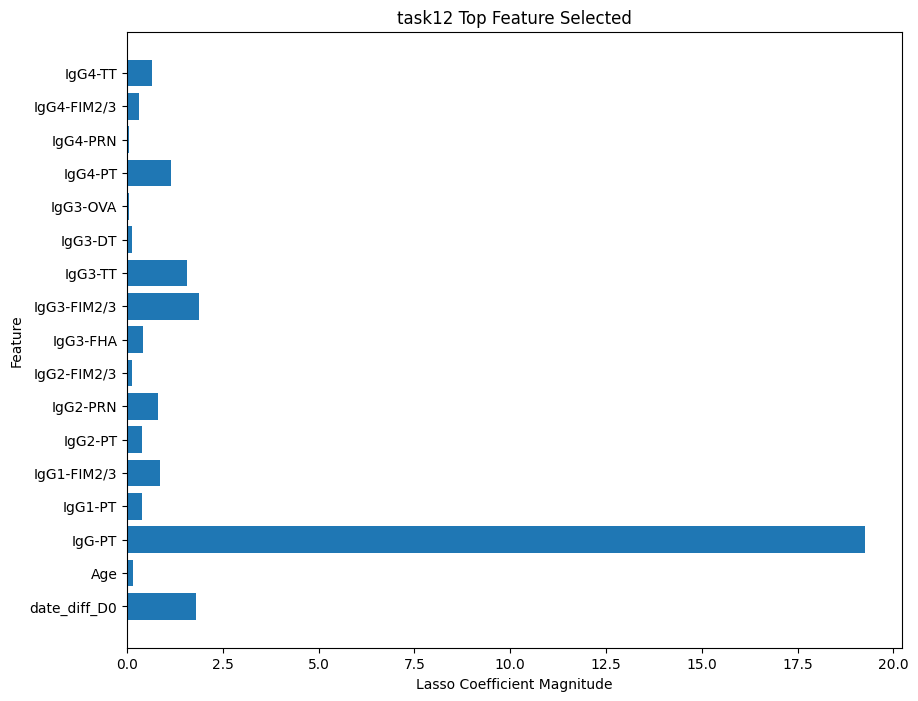

Saved model evaluation metrics to CSV.


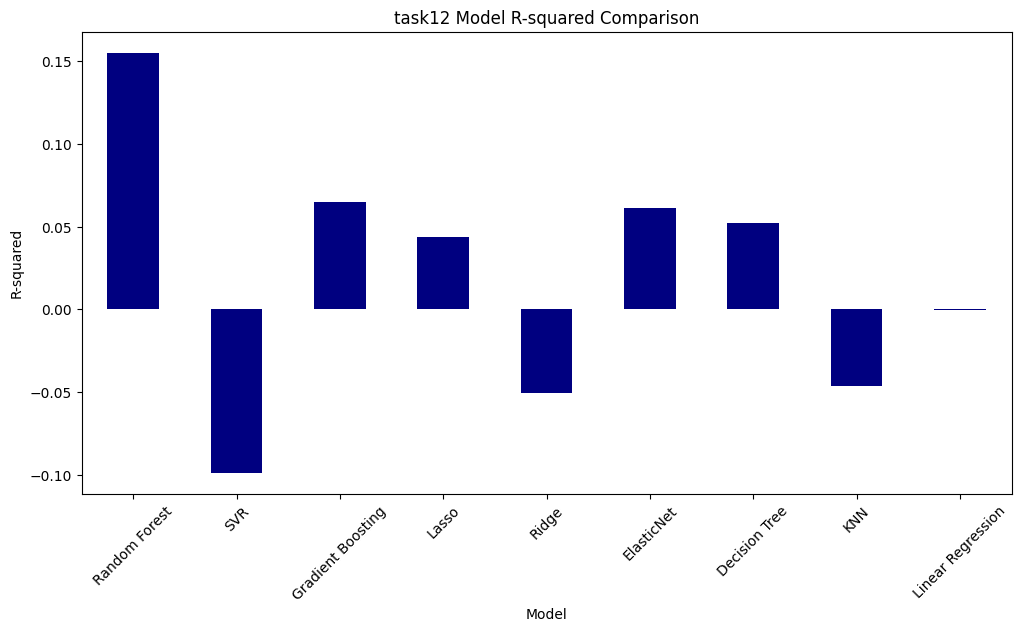

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.898494  1.120178   0.155074            0.158007
SVR                2.469039  1.218737  -0.098848           -0.098464
Gradient Boosting  2.100520  1.201520   0.065162            0.066522
Lasso              2.149133  1.168446   0.043526            0.045095
Ridge              2.360886  1.197960  -0.050714           -0.049743
ElasticNet         2.108799  1.145094   0.061477            0.061607
Decision Tree      2.129651  1.144298   0.052197            0.062555
KNN                2.351473  1.163034  -0.046525           -0.045101
Linear Regression  2.247469  1.197937  -0.000238            0.001622
Best model (Random Forest) saved.


In [11]:
train_best_model(drop_nan_col(df_train_task12,'task12'), "task12")

Best scaler: MinMaxScaler


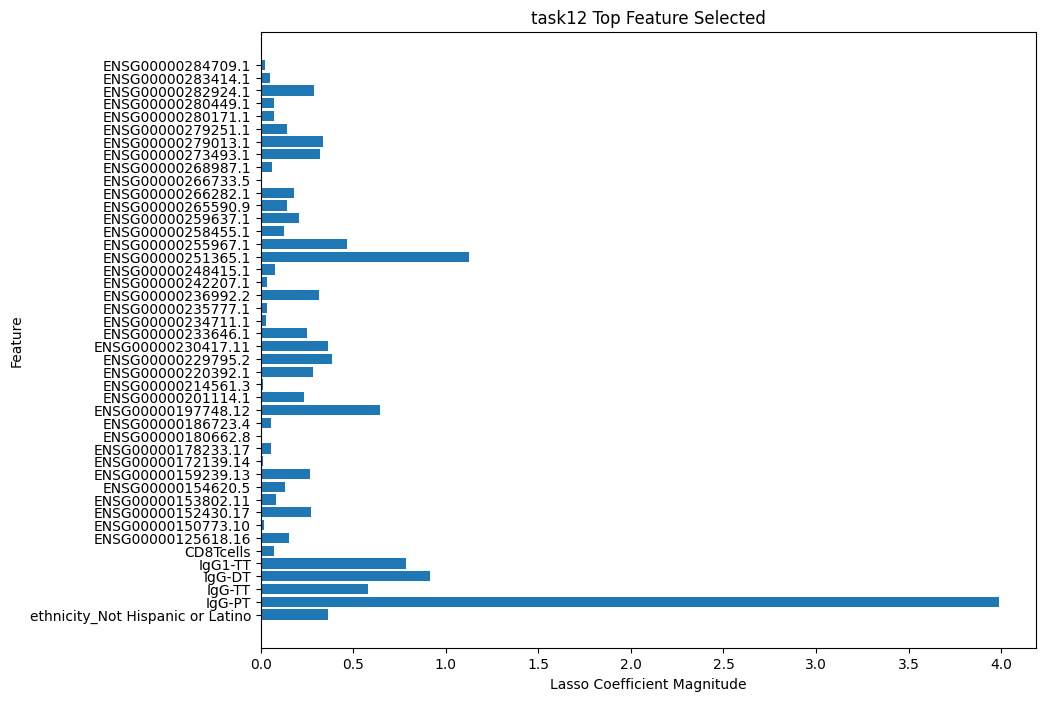

Saved model evaluation metrics to CSV.


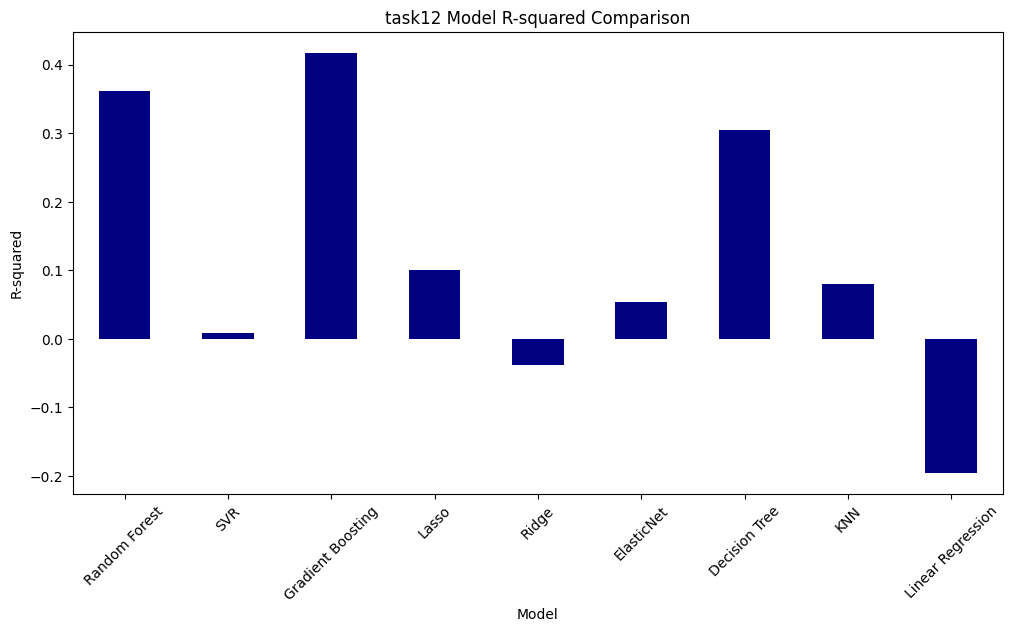

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.435839  0.922653   0.360979            0.362966
SVR                2.228014  1.249798   0.008420            0.011265
Gradient Boosting  1.309981  0.866278   0.416992            0.422272
Lasso              2.021332  1.214719   0.100404            0.104068
Ridge              2.331839  1.294431  -0.037787           -0.026935
ElasticNet         2.127319  1.242608   0.053235            0.060616
Decision Tree      1.563497  1.006070   0.304164            0.311990
KNN                2.068075  1.231497   0.079601            0.081960
Linear Regression  2.685971  1.280376  -0.195394           -0.194477
Best model (Gradient Boosting) saved.


In [12]:
train_best_model(df_train_task12.fillna(0.0), 'task12')

Best scaler: MinMaxScaler


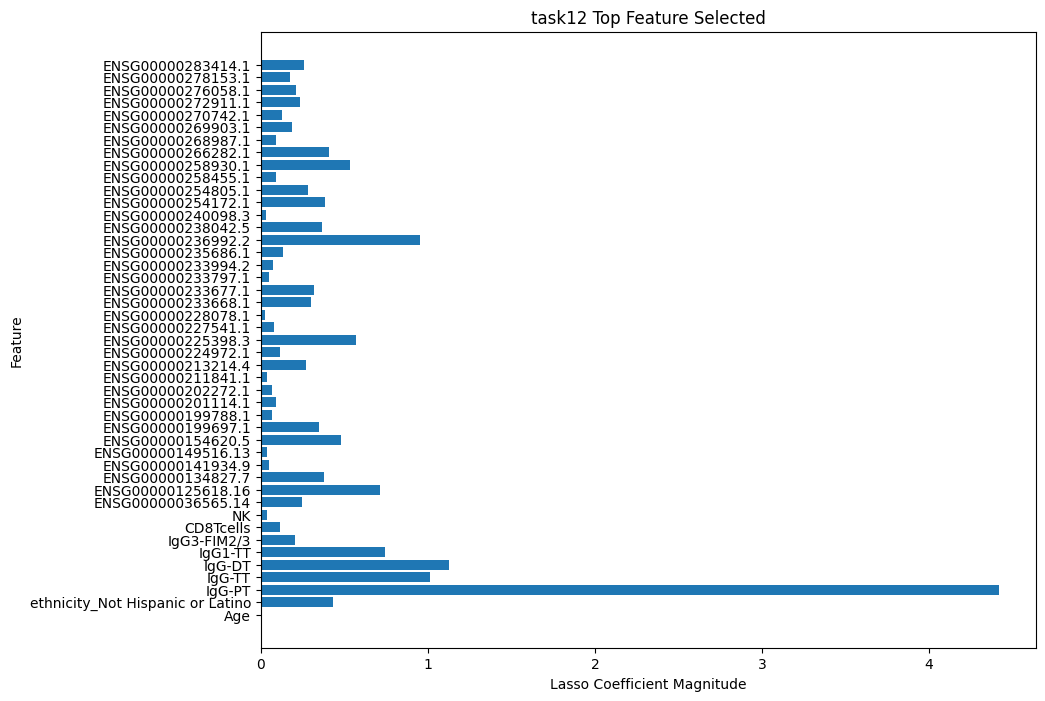

Saved model evaluation metrics to CSV.


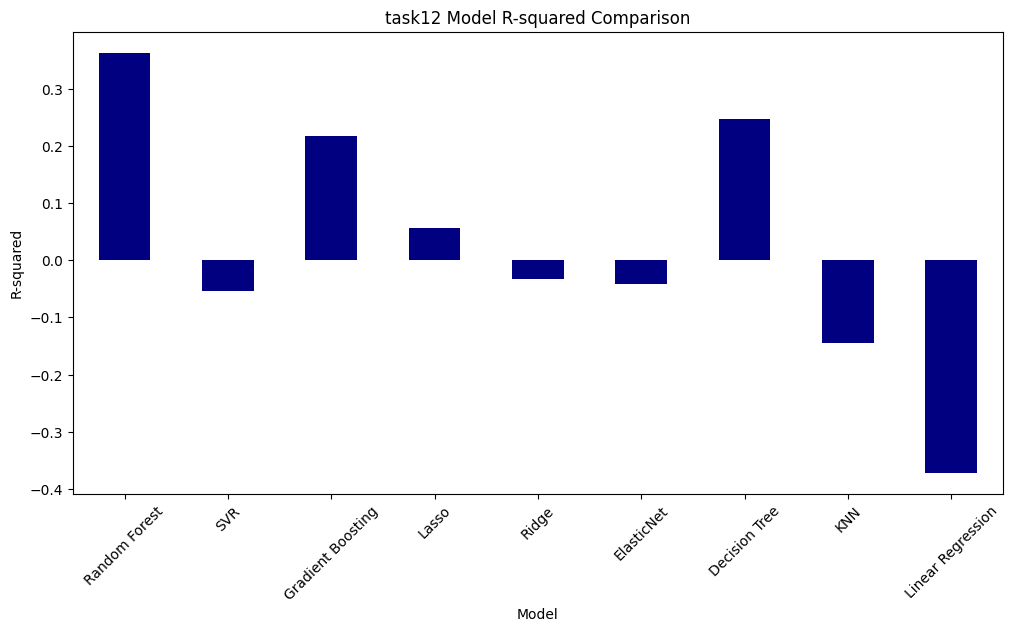

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.432140  0.911366   0.362625            0.367051
SVR                2.367839  1.231881  -0.053809           -0.050795
Gradient Boosting  1.757033  1.021856   0.218031            0.241534
Lasso              2.120791  1.191858   0.056140            0.063832
Ridge              2.318764  1.233407  -0.031968           -0.017779
ElasticNet         2.339491  1.224764  -0.041193           -0.030181
Decision Tree      1.693698  1.006321   0.246218            0.286982
KNN                2.571563  1.344298  -0.144477           -0.126823
Linear Regression  3.082748  1.384853  -0.371980           -0.371629
Best model (Random Forest) saved.


In [13]:
train_best_model(df_train_task12.fillna(1.0), 'task12')

Best scaler: MinMaxScaler


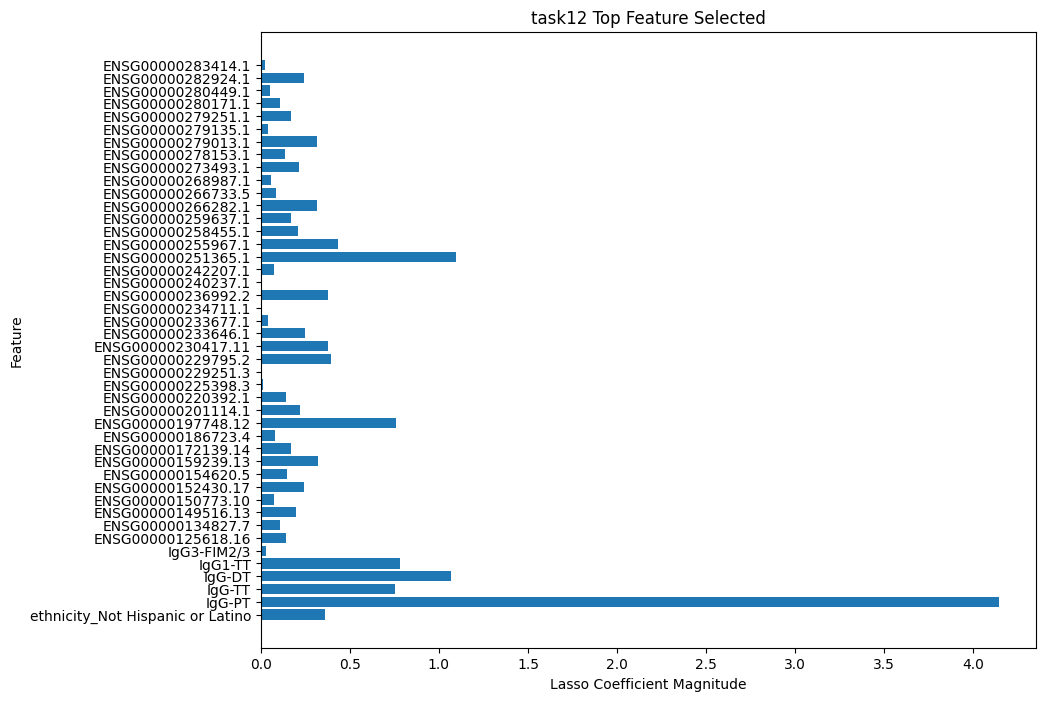

Saved model evaluation metrics to CSV.


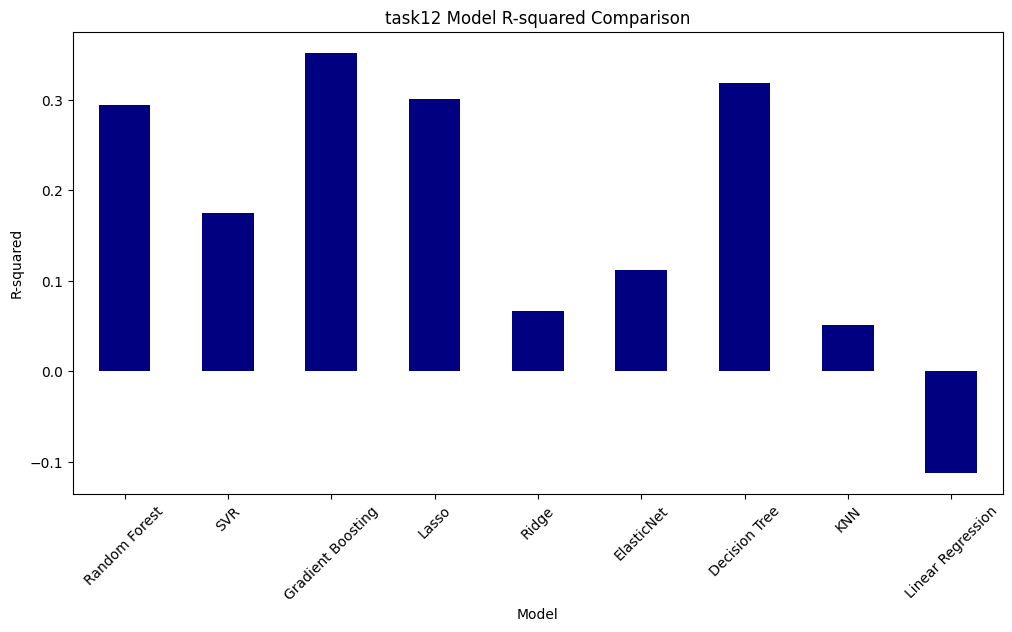

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.587047  0.994672   0.293683            0.329526
SVR                1.853762  1.131055   0.174982            0.175252
Gradient Boosting  1.456848  0.928099   0.351628            0.364279
Lasso              1.571799  1.055922   0.300469            0.300777
Ridge              2.096765  1.226313   0.066833            0.068550
ElasticNet         1.995644  1.195764   0.111837            0.113485
Decision Tree      1.531644  1.018125   0.318341            0.342374
KNN                2.132855  1.189306   0.050771            0.096669
Linear Regression  2.498599  1.315324  -0.112004            0.092698
Best model (Gradient Boosting) saved.


In [14]:
train_best_model(df_train_task12.fillna(df_train_task12.median()), 'task12')

Best scaler: Normalizer


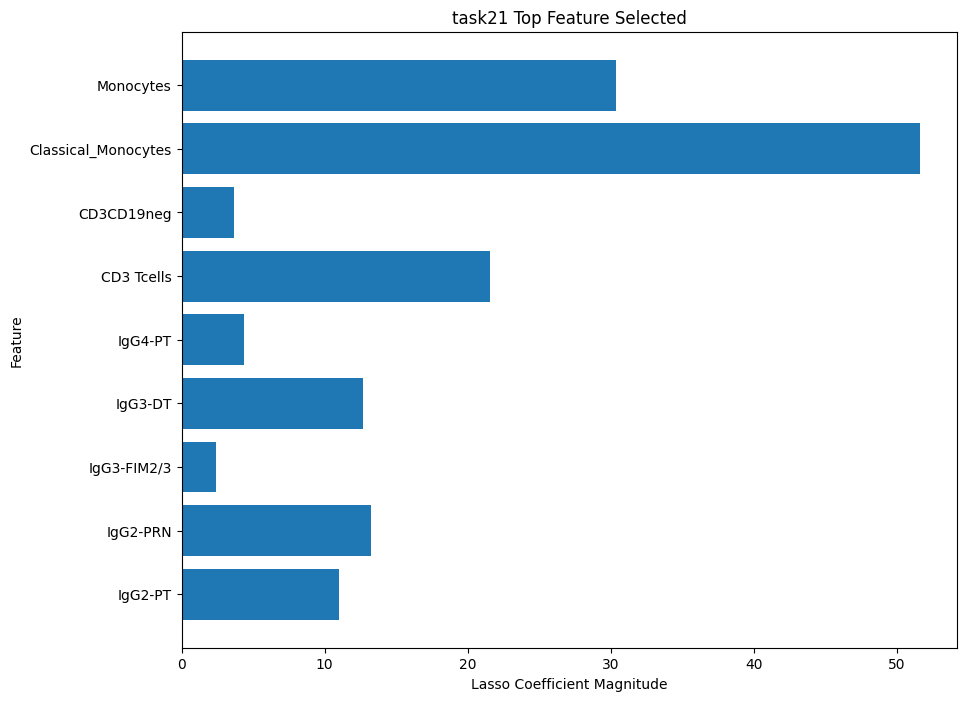

Saved model evaluation metrics to CSV.


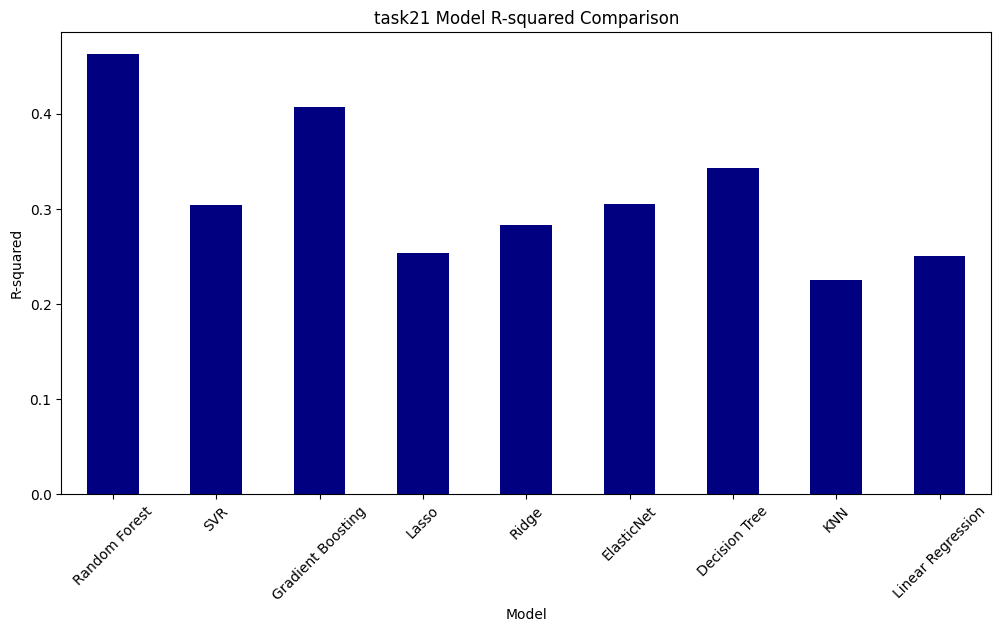

                         MSE       MAE  R-squared  Explained Variance
Model                                                                
Random Forest      52.545724  5.977246   0.462727            0.463647
SVR                68.062946  6.647382   0.304066            0.316403
Gradient Boosting  57.977699  6.024800   0.407186            0.410112
Lasso              72.977396  7.079913   0.253816            0.255634
Ridge              70.170991  6.897750   0.282511            0.284061
ElasticNet         67.983535  6.746198   0.304878            0.307406
Decision Tree      64.235105  5.786461   0.343205            0.372052
KNN                75.783664  6.567827   0.225122            0.265277
Linear Regression  73.282763  7.094939   0.250694            0.252560
Best model (Random Forest) saved.


In [15]:
train_best_model(drop_nan_col(df_train_task21,'task21'), "task21")

Best scaler: StandardScaler


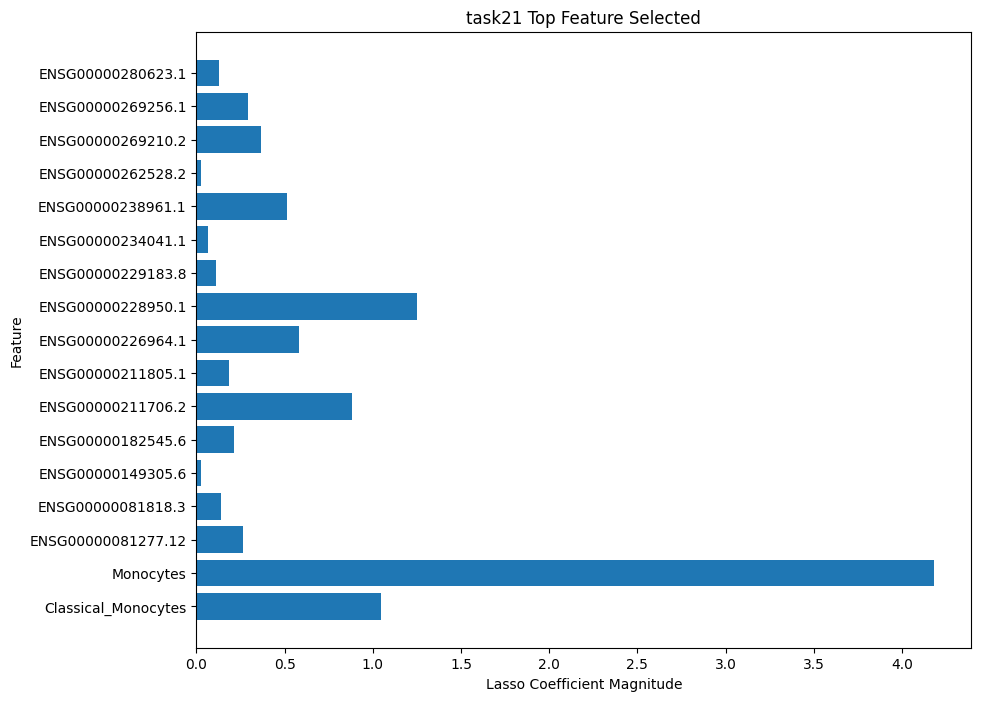

/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.072e+00, tolerance: 4.349e-01
  model = cd_fast.enet_coordinate_descent(
/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.672e+00, tolerance: 2.940e-01
  model = cd_fast.enet_coordinate_descent(
/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Saved model evaluation metrics to CSV.


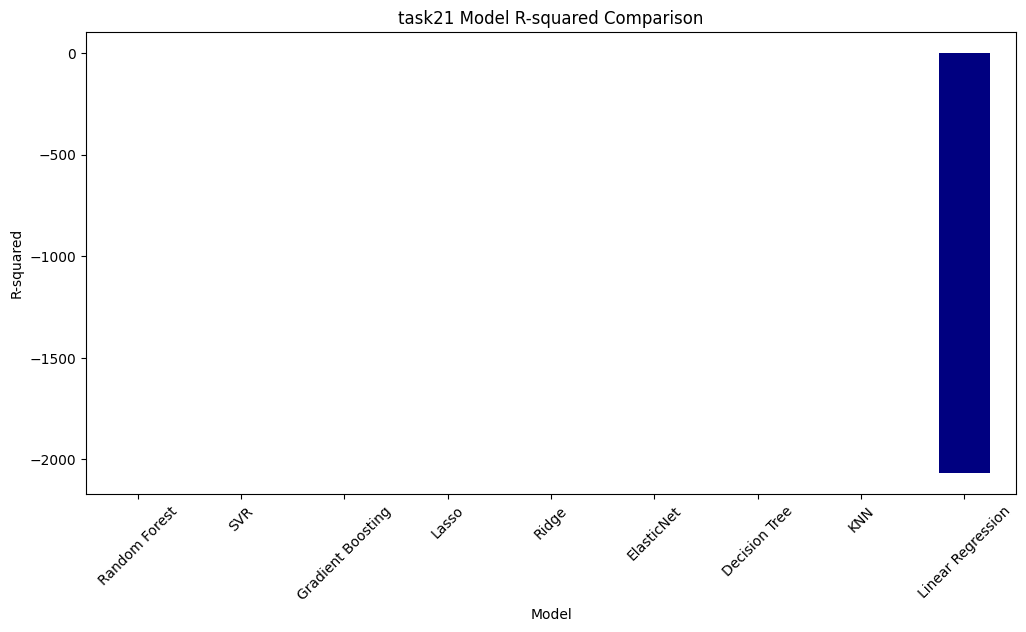

                             MSE         MAE    R-squared  Explained Variance
Model                                                                        
Random Forest          66.561456    7.066442     0.319418            0.343648
SVR                    85.244397    7.741806     0.128388            0.163076
Gradient Boosting      82.164090    8.144749     0.159884            0.179308
Lasso                  88.471685    7.994689     0.095389            0.098027
Ridge                  83.539703    7.918444     0.145818            0.155232
ElasticNet             82.700686    7.790459     0.154397            0.165106
Decision Tree          98.266822    8.314578    -0.004765            0.128239
KNN                   104.754917    8.400373    -0.071105           -0.047062
Linear Regression  202330.433629  166.177992 -2067.800796        -1813.550010
Best model (Random Forest) saved.


In [16]:
train_best_model(df_train_task21.fillna(0.0), 'task21')

Best scaler: RobustScaler


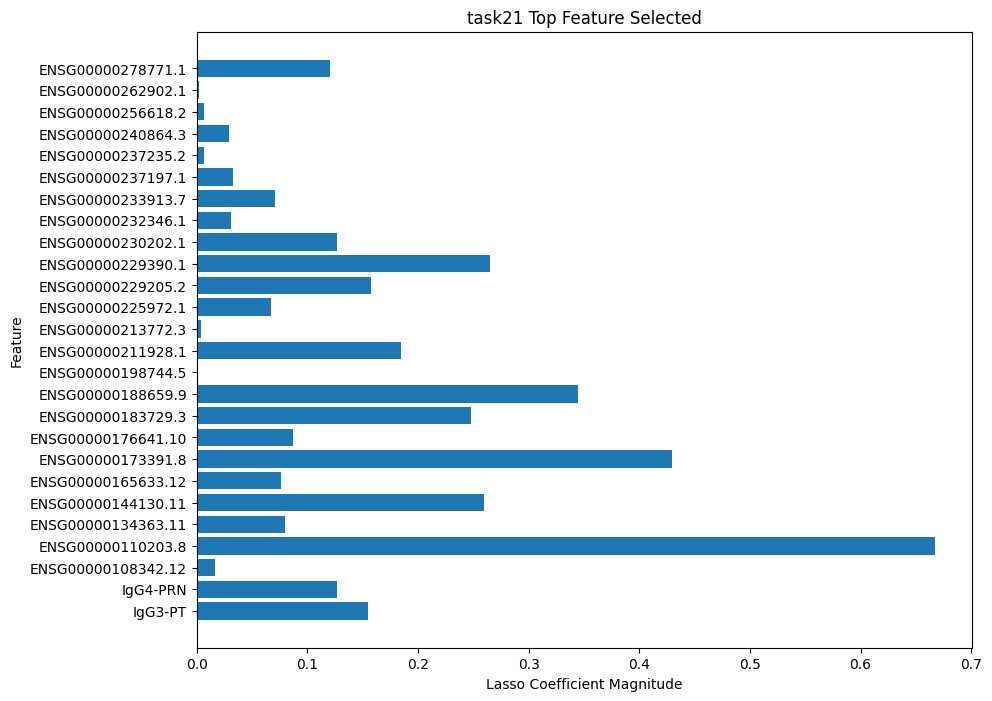

/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e+01, tolerance: 3.678e-01
  model = cd_fast.enet_coordinate_descent(
/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+01, tolerance: 2.940e-01
  model = cd_fast.enet_coordinate_descent(
/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Saved model evaluation metrics to CSV.


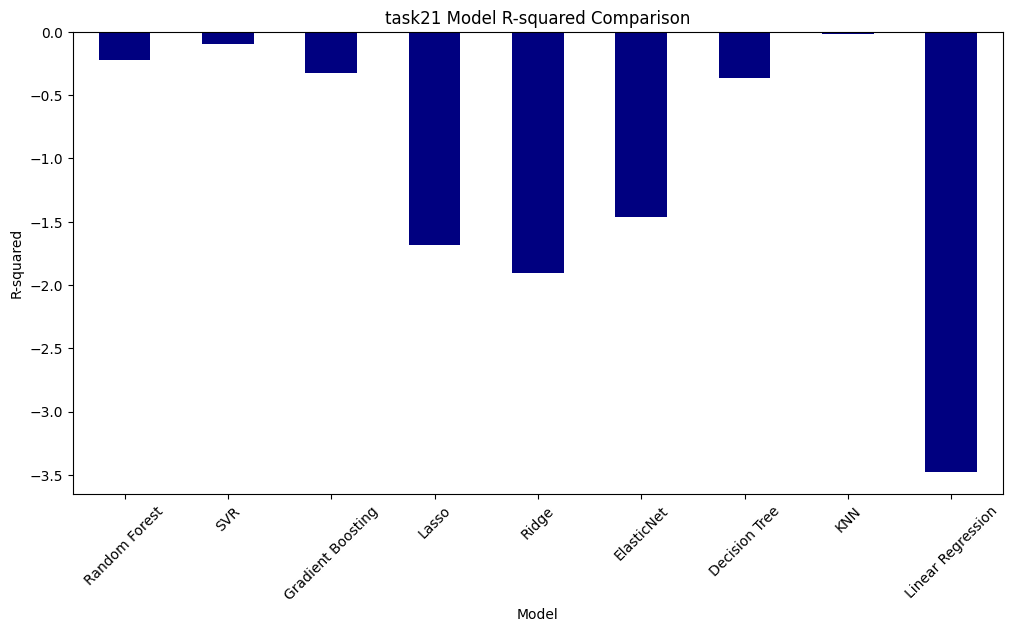

                          MSE        MAE  R-squared  Explained Variance
Model                                                                  
Random Forest      119.292953   9.189938  -0.219754           -0.217137
SVR                107.527107   8.268780  -0.099450            0.002810
Gradient Boosting  129.254801   9.397420  -0.321613           -0.315571
Lasso              262.210787  12.238405  -1.681069           -1.653228
Ridge              284.383906  13.192416  -1.907786           -1.851295
ElasticNet         240.925948  11.903360  -1.463435           -1.439349
Decision Tree      133.672193   9.964148  -0.366780           -0.352071
KNN                 99.252370   8.131317  -0.014842            0.018564
Linear Regression  437.835108  16.950685  -3.476804           -3.125225
Best model (KNN) saved.


In [17]:
train_best_model(df_train_task21.fillna(1.0), 'task21')

Best scaler: StandardScaler


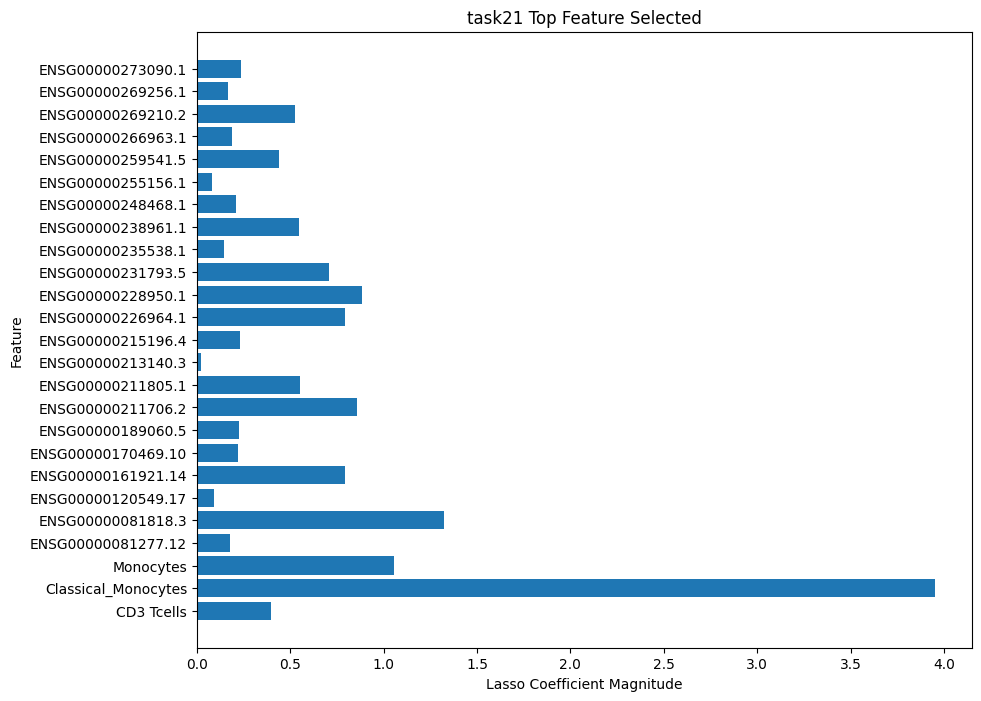

/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.058e+00, tolerance: 3.678e-01
  model = cd_fast.enet_coordinate_descent(
/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.235e-01, tolerance: 2.940e-01
  model = cd_fast.enet_coordinate_descent(
/home/ch3ngp3ng/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Saved model evaluation metrics to CSV.


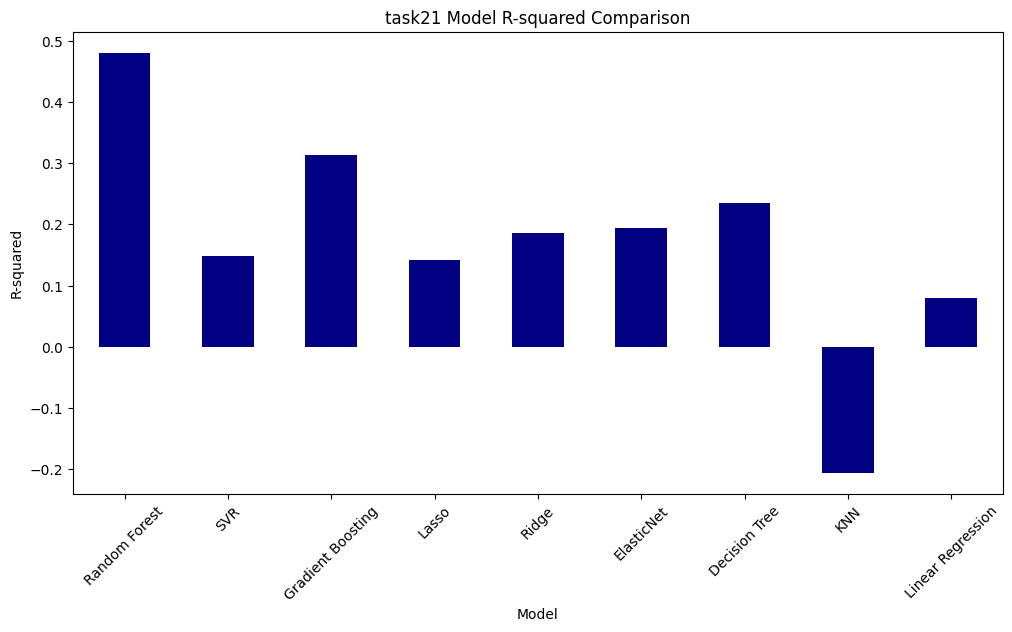

                          MSE       MAE  R-squared  Explained Variance
Model                                                                 
Random Forest       50.845853  6.248635   0.480108            0.494696
SVR                 83.326840  7.458995   0.147995            0.183951
Gradient Boosting   67.209029  7.143004   0.312797            0.324122
Lasso               83.962231  7.651442   0.141498            0.173088
Ridge               79.679521  7.334898   0.185288            0.217471
ElasticNet          78.880848  7.290568   0.193454            0.228272
Decision Tree       74.756716  6.385781   0.235623            0.375422
KNN                117.909018  9.488629  -0.205603           -0.204751
Linear Regression   89.947766  8.000570   0.080296            0.115773
Best model (Random Forest) saved.


In [18]:
train_best_model(df_train_task21.fillna(df_train_task21.median()), "task21")

Best scaler: MinMaxScaler


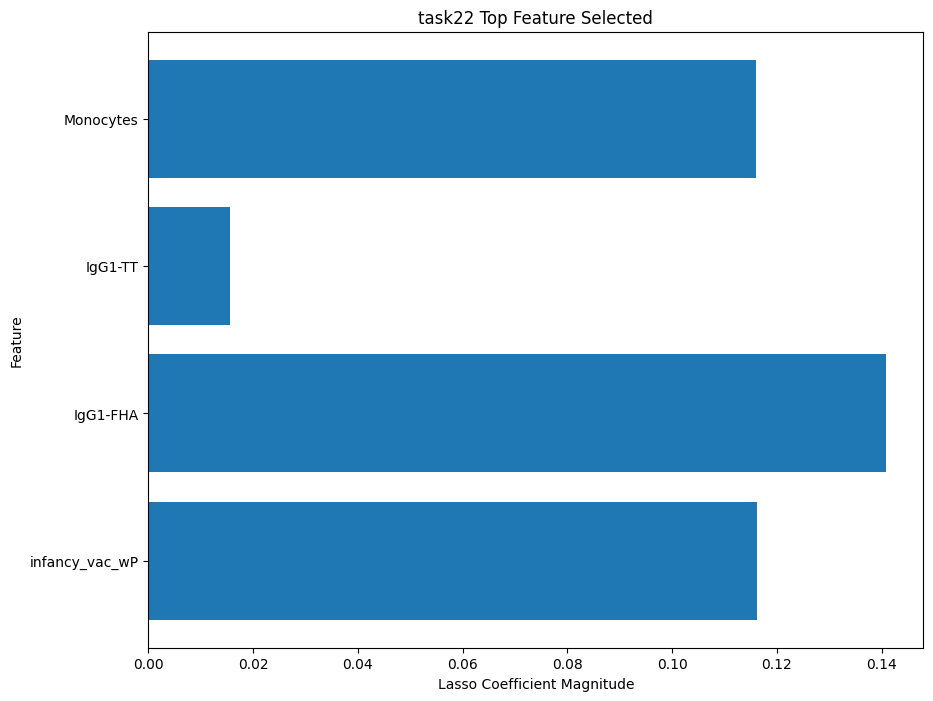

Saved model evaluation metrics to CSV.


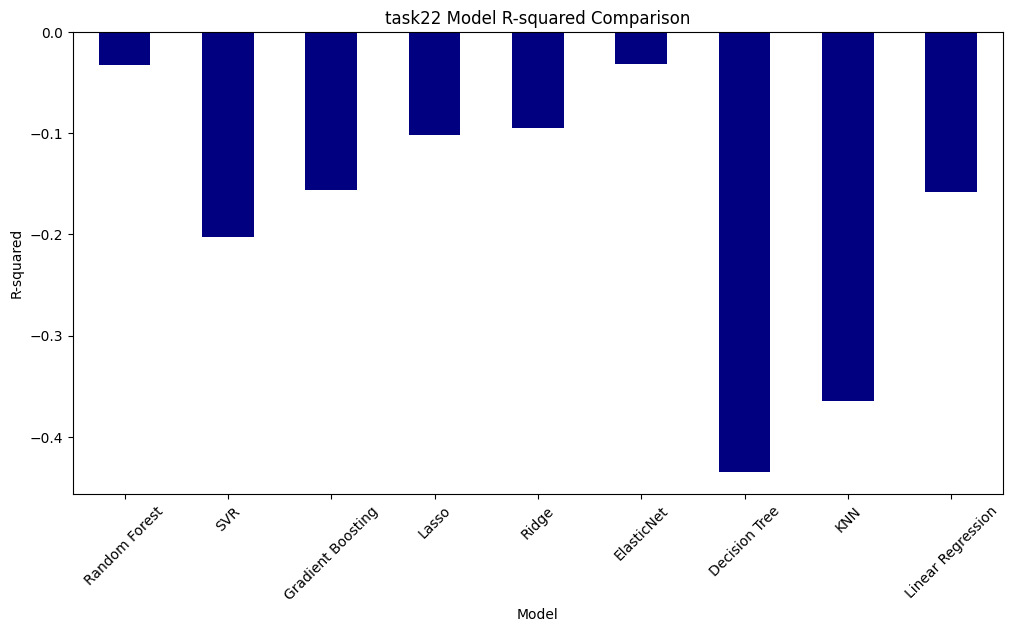

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      0.203801  0.383355  -0.032991            0.066377
SVR                0.237265  0.420319  -0.202612           -0.154812
Gradient Boosting  0.228155  0.398227  -0.156436           -0.123273
Lasso              0.217447  0.398913  -0.102160           -0.077709
Ridge              0.215959  0.398106  -0.094619           -0.067556
ElasticNet         0.203599  0.377689  -0.031971           -0.009949
Decision Tree      0.283056  0.467603  -0.434707           -0.380310
KNN                0.269280  0.420235  -0.364885           -0.345747
Linear Regression  0.228427  0.410762  -0.157813           -0.129692
Best model (ElasticNet) saved.


In [19]:
train_best_model(drop_nan_col(df_train_task22,'task22'), "task22")

Best scaler: StandardScaler


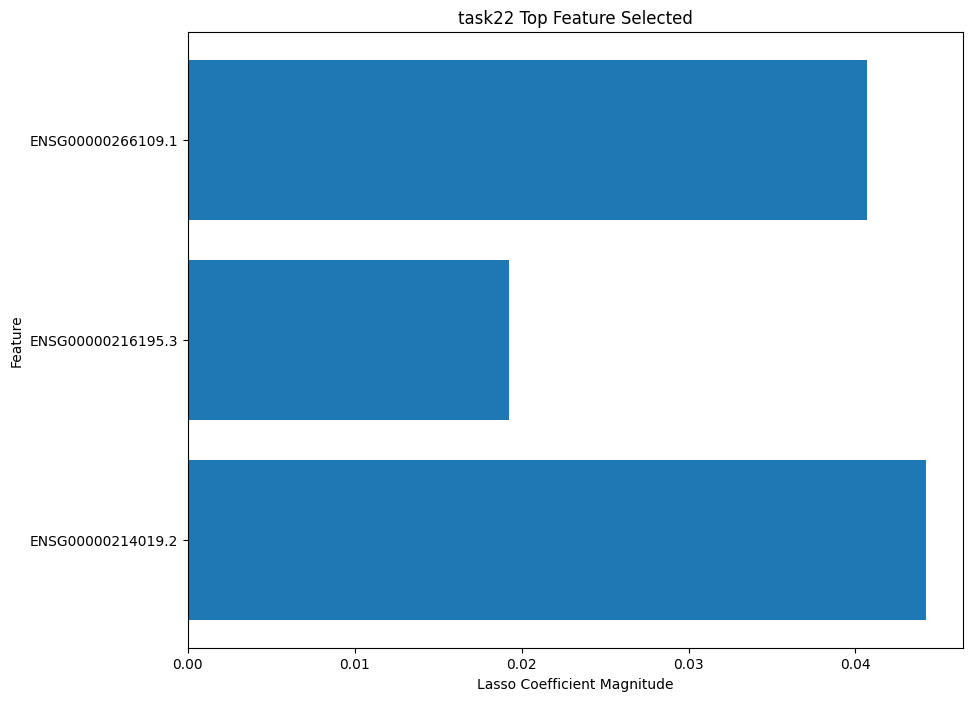

Saved model evaluation metrics to CSV.


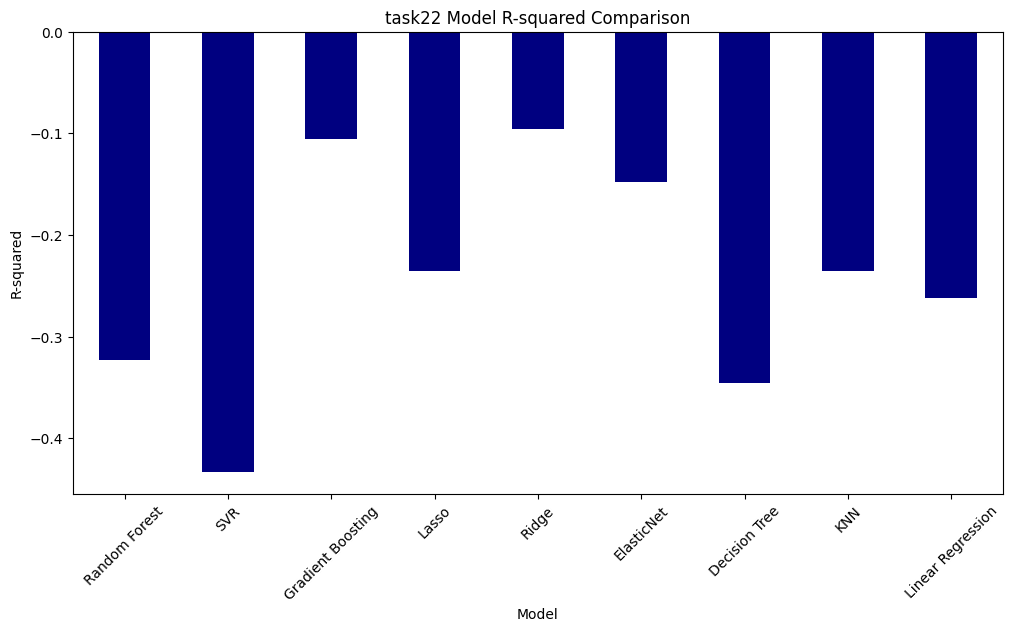

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      0.260965  0.398645  -0.322737           -0.316744
SVR                0.282768  0.422741  -0.433248           -0.361597
Gradient Boosting  0.218178  0.372065  -0.105866           -0.100797
Lasso              0.243700  0.398790  -0.235228           -0.222113
Ridge              0.216206  0.372223  -0.095871           -0.084763
ElasticNet         0.226430  0.382344  -0.147689           -0.135644
Decision Tree      0.265564  0.379230  -0.346046           -0.317374
KNN                0.243656  0.383427  -0.235003           -0.234885
Linear Regression  0.249060  0.401908  -0.262396           -0.247548
Best model (Ridge) saved.


In [20]:
train_best_model(df_train_task22.fillna(0.0), 'task22')

Best scaler: MinMaxScaler


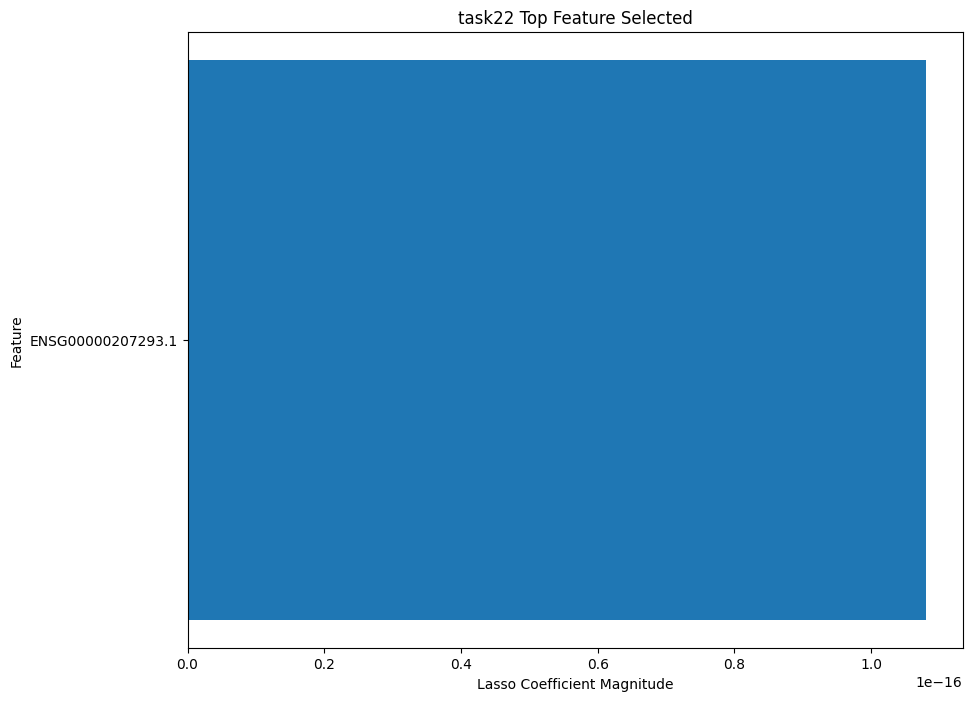

Saved model evaluation metrics to CSV.


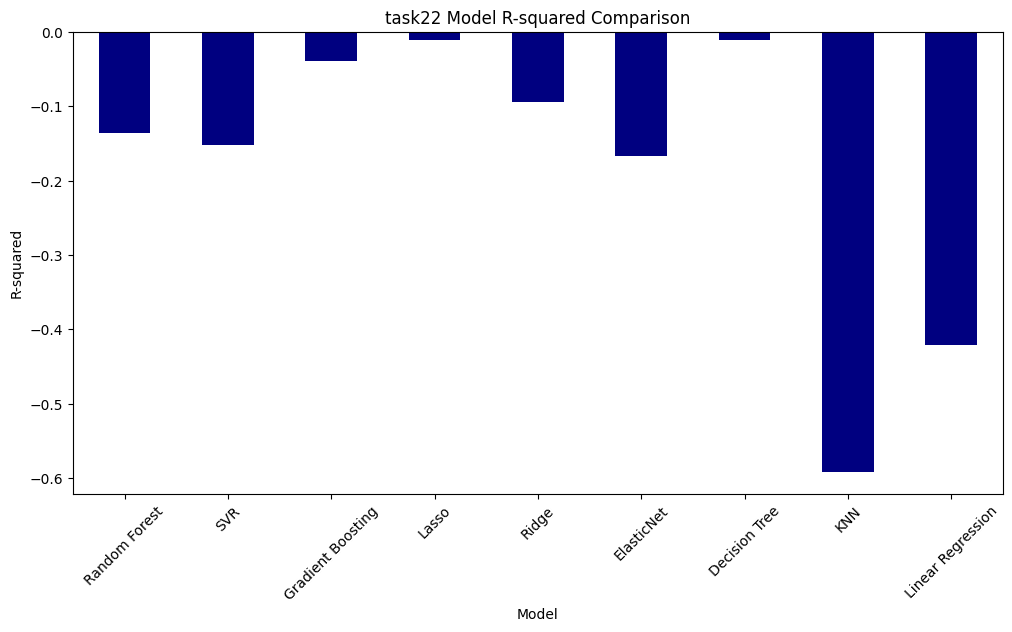

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      0.223984  0.390101  -0.135295           -0.089144
SVR                0.227301  0.394031  -0.152106           -0.101554
Gradient Boosting  0.204920  0.371258  -0.038663            0.000000
Lasso              0.199450  0.361037  -0.010938            0.000000
Ridge              0.215996  0.377369  -0.094804           -0.081242
ElasticNet         0.230176  0.388208  -0.166681           -0.151222
Decision Tree      0.199450  0.361037  -0.010938            0.000000
KNN                0.313979  0.452327  -0.591444           -0.540617
Linear Regression  0.280393  0.421356  -0.421209           -0.400091
Best model (Lasso) saved.


In [21]:
train_best_model(df_train_task22.fillna(1.0), 'task22')

Best scaler: Normalizer


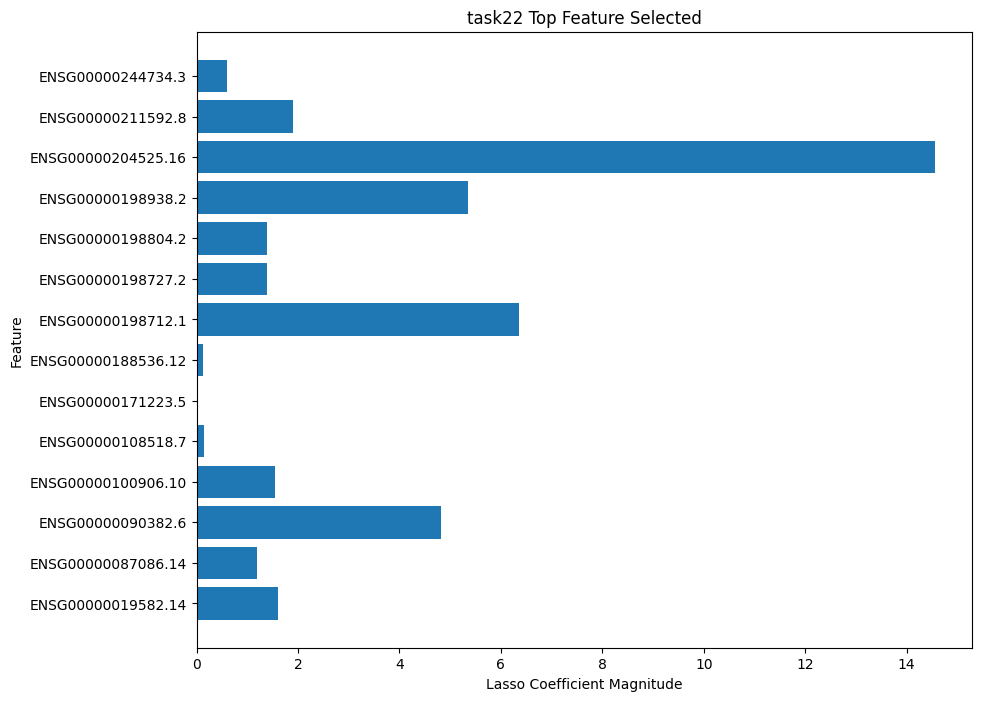

Saved model evaluation metrics to CSV.


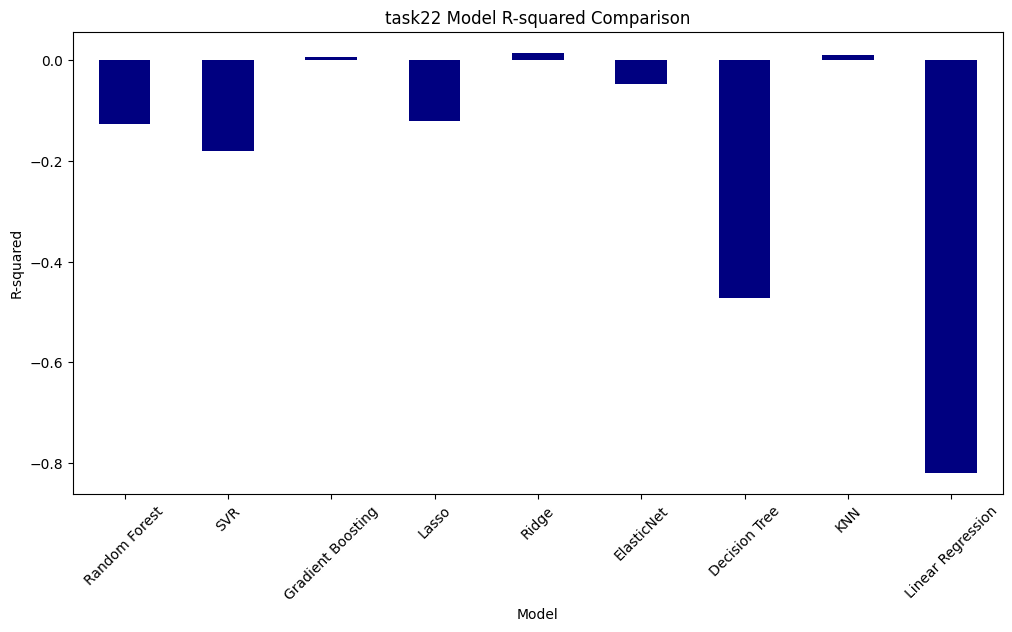

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      0.222299  0.369886  -0.126754           -0.123010
SVR                0.232786  0.388624  -0.179909           -0.179829
Gradient Boosting  0.196222  0.361849   0.005423            0.009606
Lasso              0.221046  0.404321  -0.120400           -0.120373
Ridge              0.194439  0.356508   0.014458            0.021164
ElasticNet         0.206814  0.381582  -0.048267           -0.048008
Decision Tree      0.290385  0.422530  -0.471858           -0.453169
KNN                0.195128  0.346590   0.010965            0.014024
Linear Regression  0.359014  0.507035  -0.819714           -0.819409
Best model (Ridge) saved.


In [22]:
train_best_model(df_train_task22.fillna(df_train_task22.median()), "task22")

Best scaler: StandardScaler


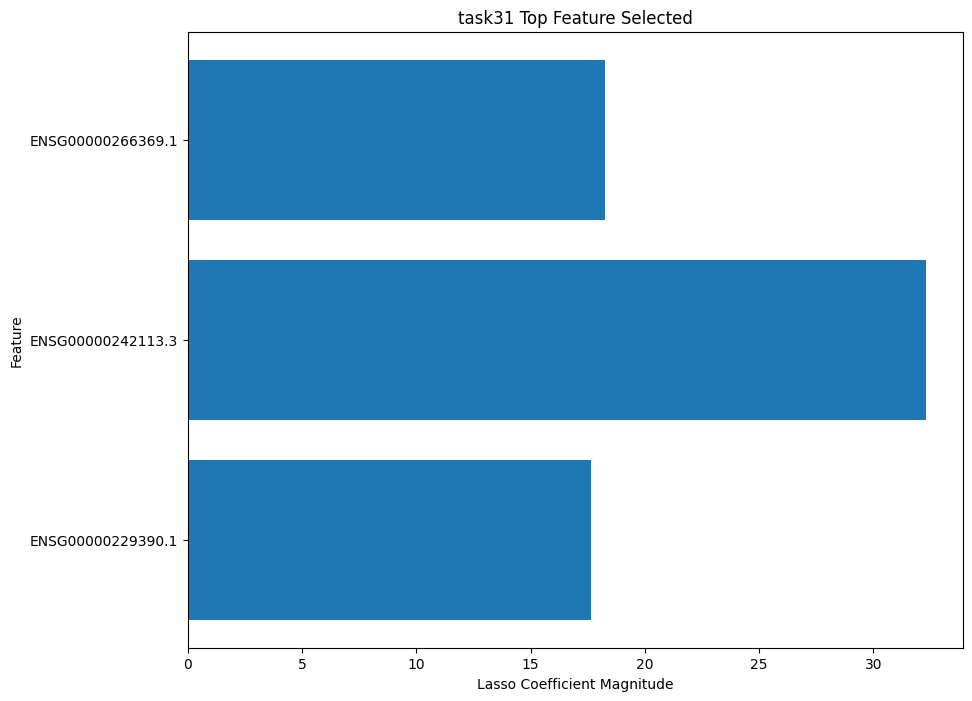

Saved model evaluation metrics to CSV.


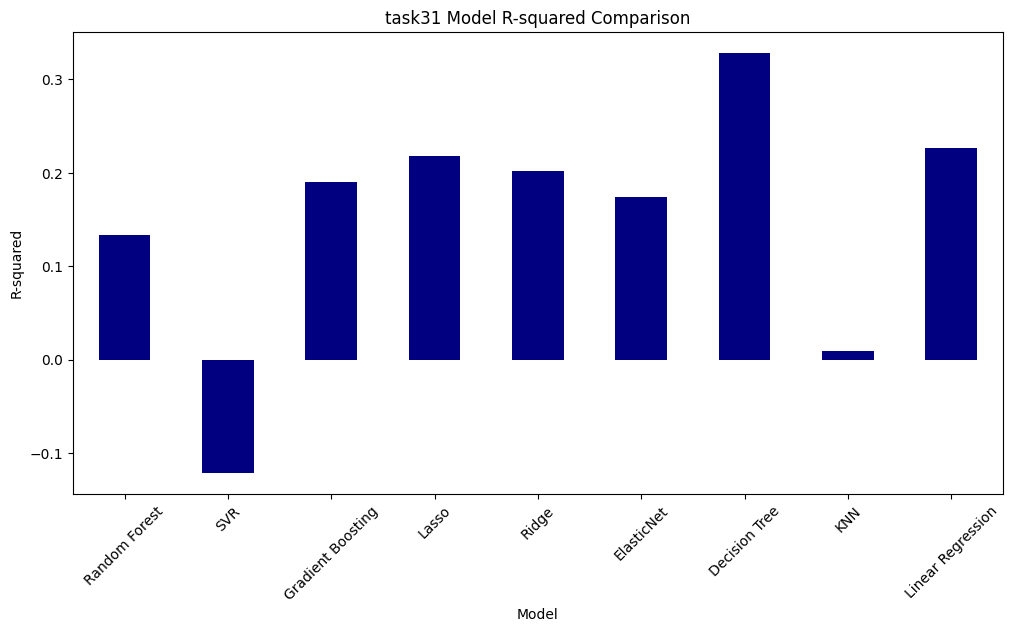

                             MSE         MAE  R-squared  Explained Variance
Model                                                                      
Random Forest      105953.670314  175.518509   0.133867            0.197390
SVR                137174.283853  172.990333  -0.121350            0.072416
Gradient Boosting   99096.341125  181.241698   0.189924            0.219705
Lasso               95695.477711  167.018628   0.217724            0.270889
Ridge               97687.463092  169.711149   0.201441            0.254547
ElasticNet         101083.086122  172.580719   0.173683            0.230878
Decision Tree       82169.833877  171.234409   0.328292            0.346909
KNN                121185.128564  172.356325   0.009356            0.143516
Linear Regression   94622.629527  167.211679   0.226495            0.276737
Best model (Decision Tree) saved.


In [23]:
train_best_model(drop_nan_col(df_train_task31,'task31'), "task31")

Best scaler: StandardScaler


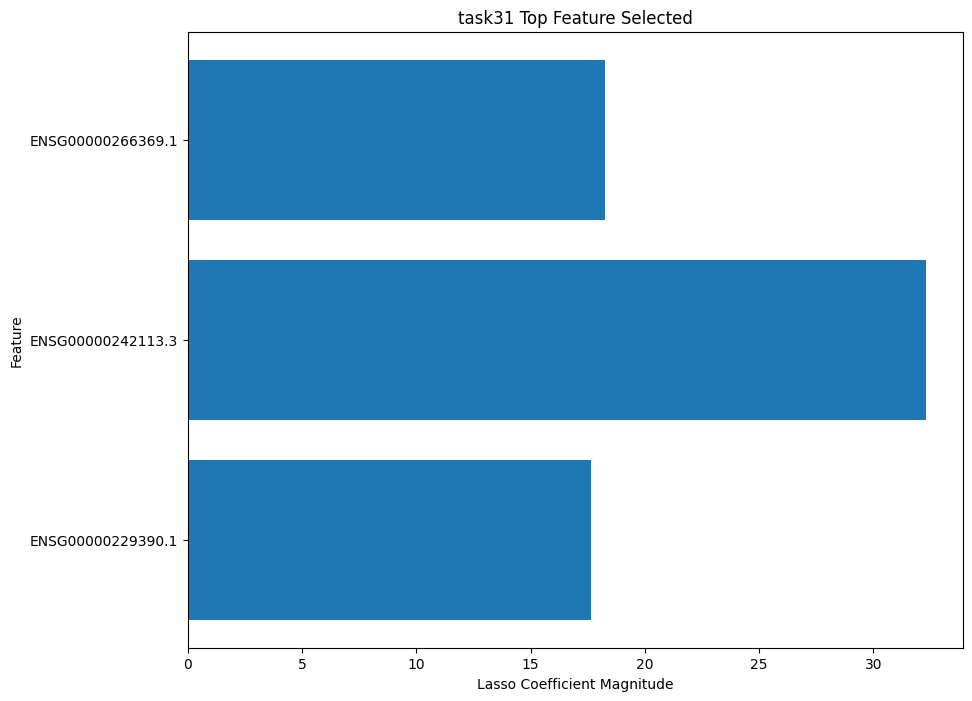

Saved model evaluation metrics to CSV.


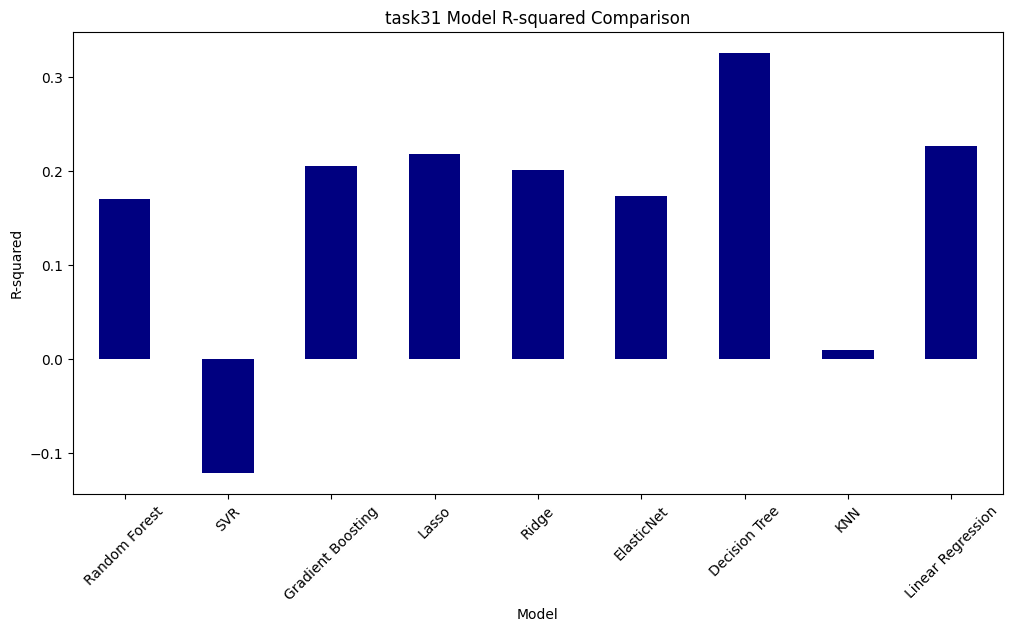

                             MSE         MAE  R-squared  Explained Variance
Model                                                                      
Random Forest      101532.121788  172.401844   0.170012            0.228155
SVR                137174.283853  172.990333  -0.121350            0.072416
Gradient Boosting   97204.992795  179.003739   0.205385            0.234962
Lasso               95695.477711  167.018628   0.217724            0.270889
Ridge               97687.463092  169.711149   0.201441            0.254547
ElasticNet         101083.086122  172.580719   0.173683            0.230878
Decision Tree       82461.338012  167.753349   0.325909            0.343214
KNN                121185.128564  172.356325   0.009356            0.143516
Linear Regression   94622.629527  167.211679   0.226495            0.276737
Best model (Decision Tree) saved.


In [24]:
train_best_model(df_train_task31.fillna(0.0), 'task31')

Best scaler: StandardScaler


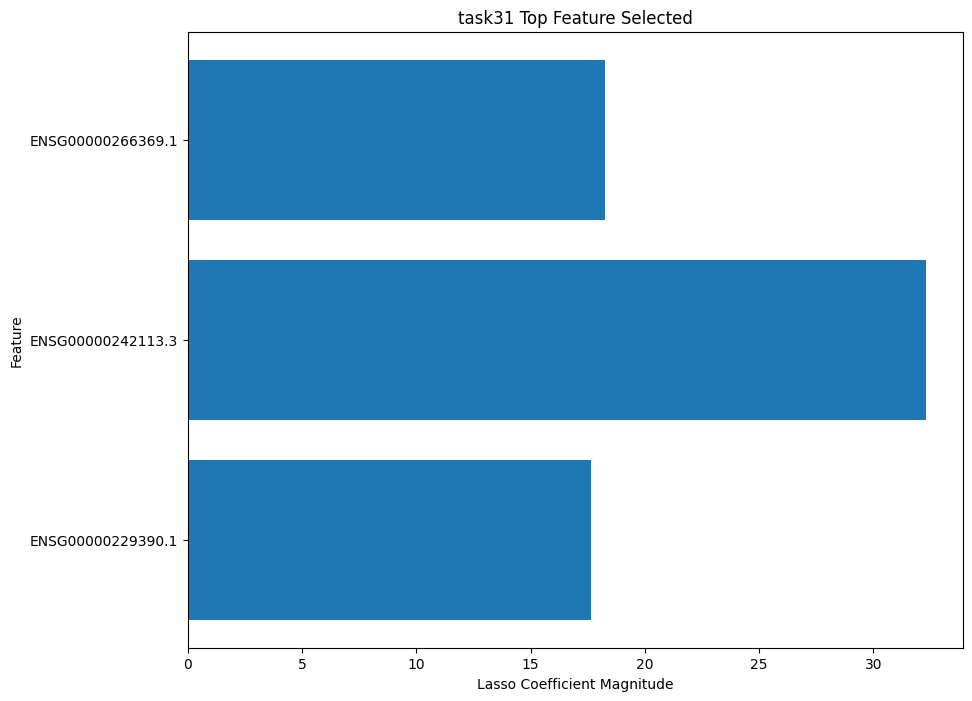

Saved model evaluation metrics to CSV.


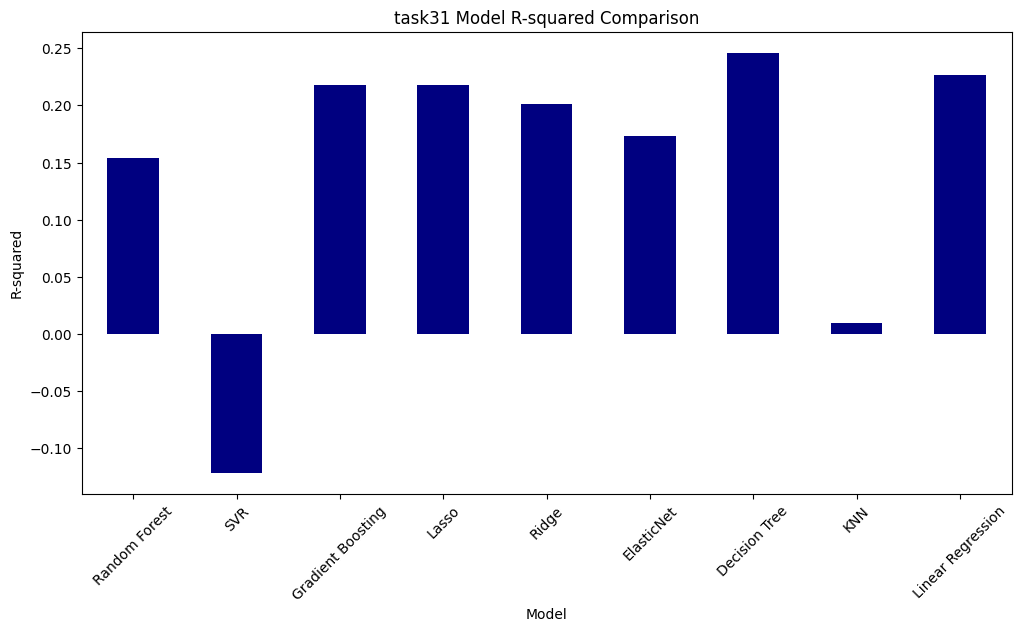

                             MSE         MAE  R-squared  Explained Variance
Model                                                                      
Random Forest      103517.890661  172.390233   0.153779            0.218549
SVR                137174.283853  172.990333  -0.121350            0.072416
Gradient Boosting   95632.891753  176.446621   0.218236            0.250092
Lasso               95695.477711  167.018628   0.217724            0.270889
Ridge               97687.463092  169.711149   0.201441            0.254547
ElasticNet         101083.086122  172.580719   0.173683            0.230878
Decision Tree       92239.227992  180.639985   0.245978            0.274335
KNN                121185.128564  172.356325   0.009356            0.143516
Linear Regression   94622.629527  167.211679   0.226495            0.276737
Best model (Decision Tree) saved.


In [25]:
train_best_model(df_train_task31.fillna(1.0), 'task31')

Best scaler: StandardScaler


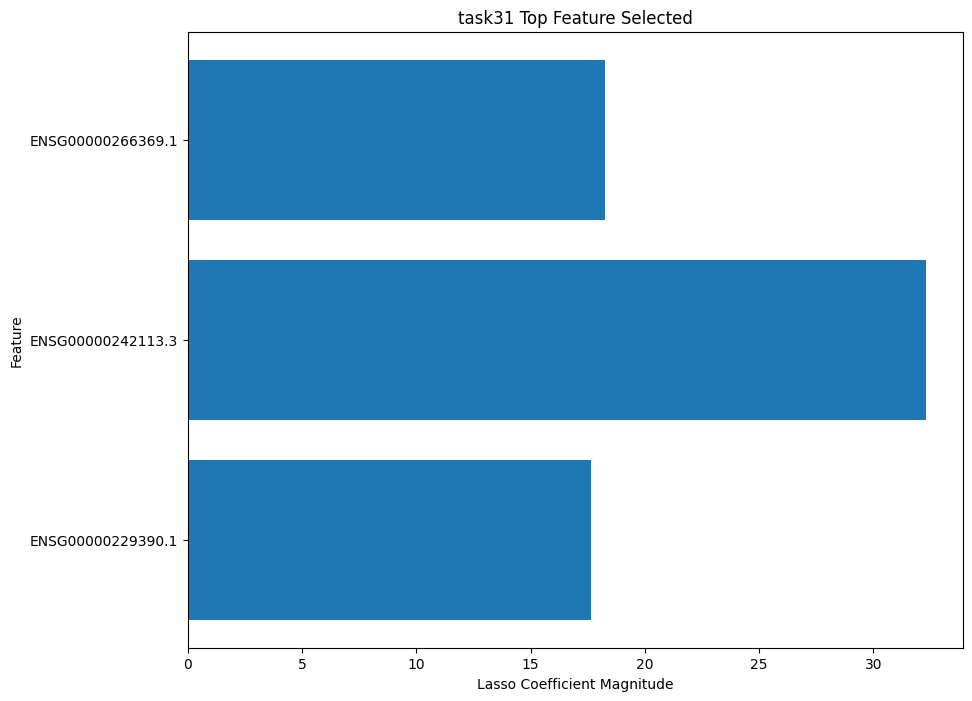

Saved model evaluation metrics to CSV.


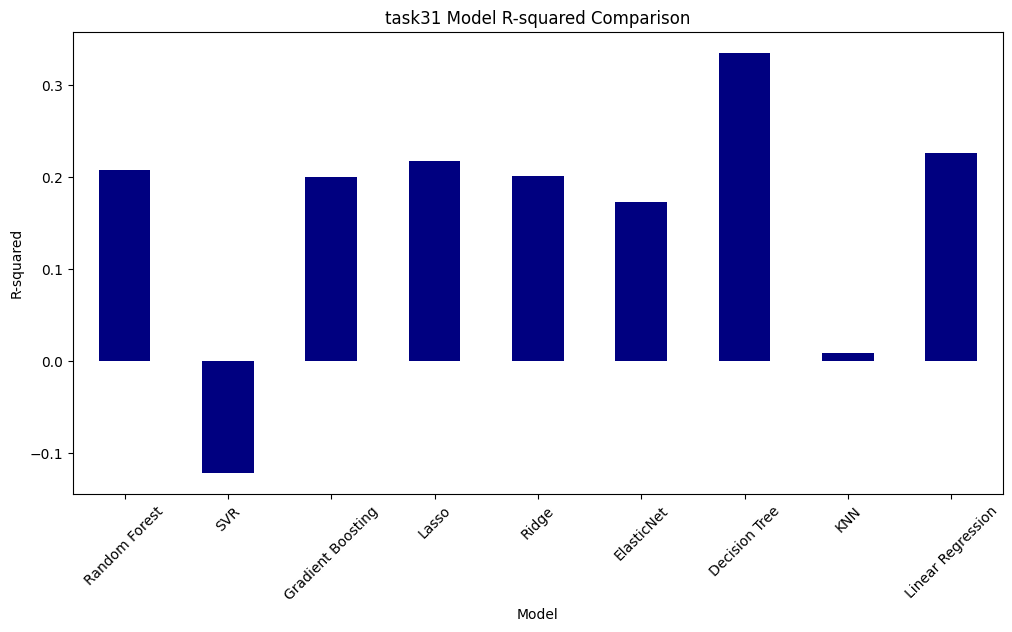

                             MSE         MAE  R-squared  Explained Variance
Model                                                                      
Random Forest       96816.395963  168.256240   0.208561            0.268213
SVR                137174.283853  172.990333  -0.121350            0.072416
Gradient Boosting   97854.817633  179.682230   0.200073            0.230239
Lasso               95695.477711  167.018628   0.217724            0.270889
Ridge               97687.463092  169.711149   0.201441            0.254547
ElasticNet         101083.086122  172.580719   0.173683            0.230878
Decision Tree       81295.036394  165.897894   0.335443            0.354172
KNN                121185.128564  172.356325   0.009356            0.143516
Linear Regression   94622.629527  167.211679   0.226495            0.276737
Best model (Decision Tree) saved.


In [26]:
train_best_model(df_train_task31.fillna(df_train_task31.median()), "task31")

Best scaler: Normalizer


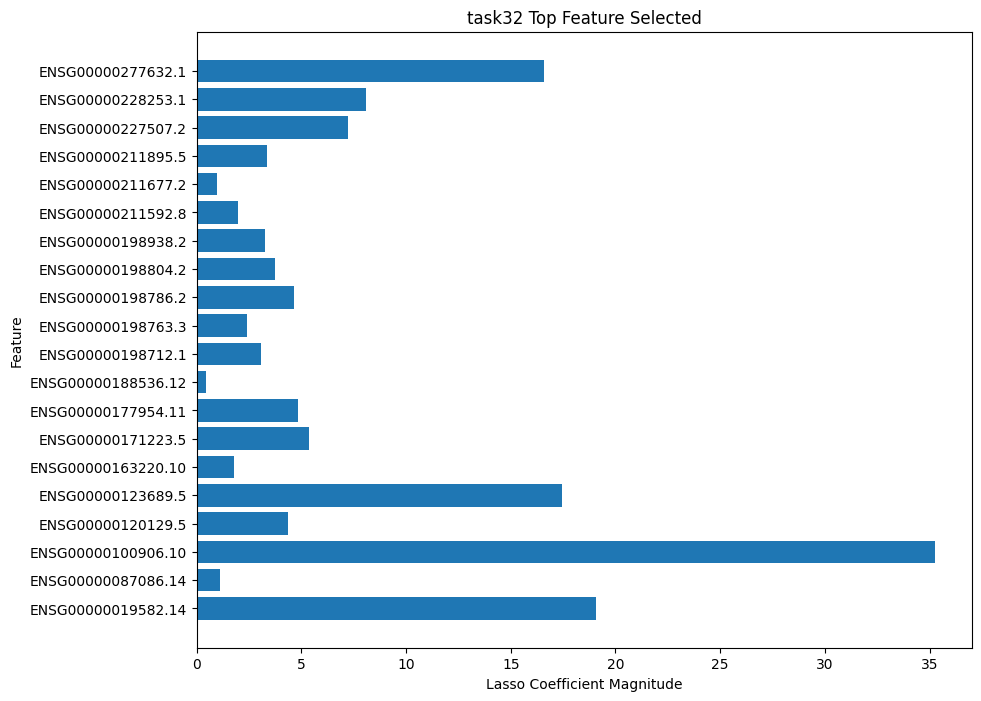

Saved model evaluation metrics to CSV.


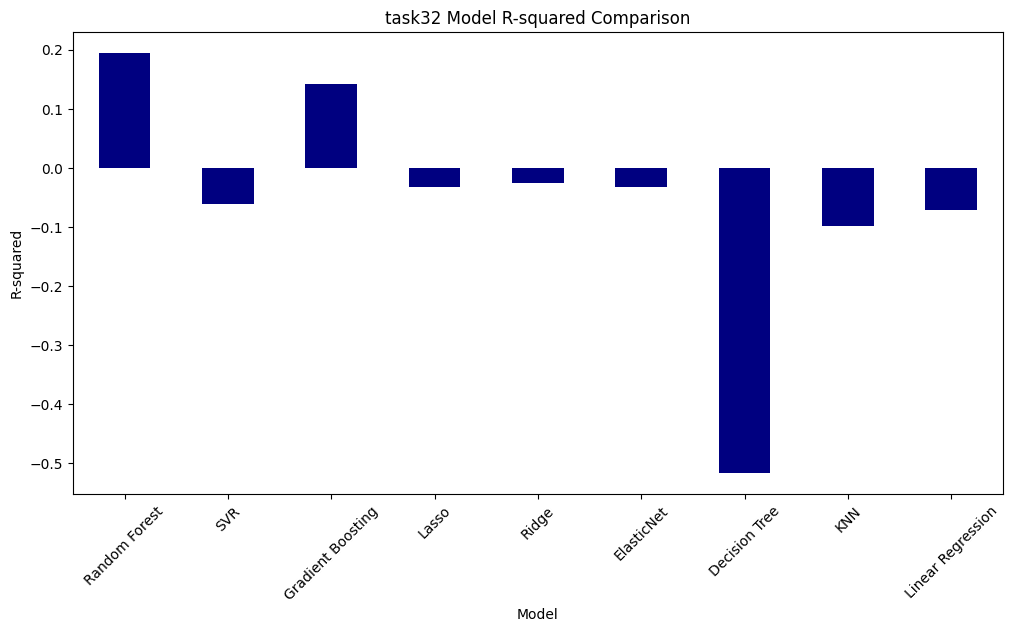

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.574518  1.010275   0.194352            0.246027
SVR                2.073840  1.158345  -0.061141           -0.047899
Gradient Boosting  1.675843  1.039509   0.142506            0.209319
Lasso              2.018517  1.130691  -0.032834            0.000000
Ridge              2.003951  1.125194  -0.025380            0.006579
ElasticNet         2.018517  1.130691  -0.032834            0.000000
Decision Tree      2.964769  1.421289  -0.517011           -0.487316
KNN                2.145887  1.172270  -0.098006           -0.064341
Linear Regression  2.093672  1.026803  -0.071289           -0.067285
Best model (Random Forest) saved.


In [27]:
train_best_model(drop_nan_col(df_train_task32,'task32'), "task32")

Best scaler: Normalizer


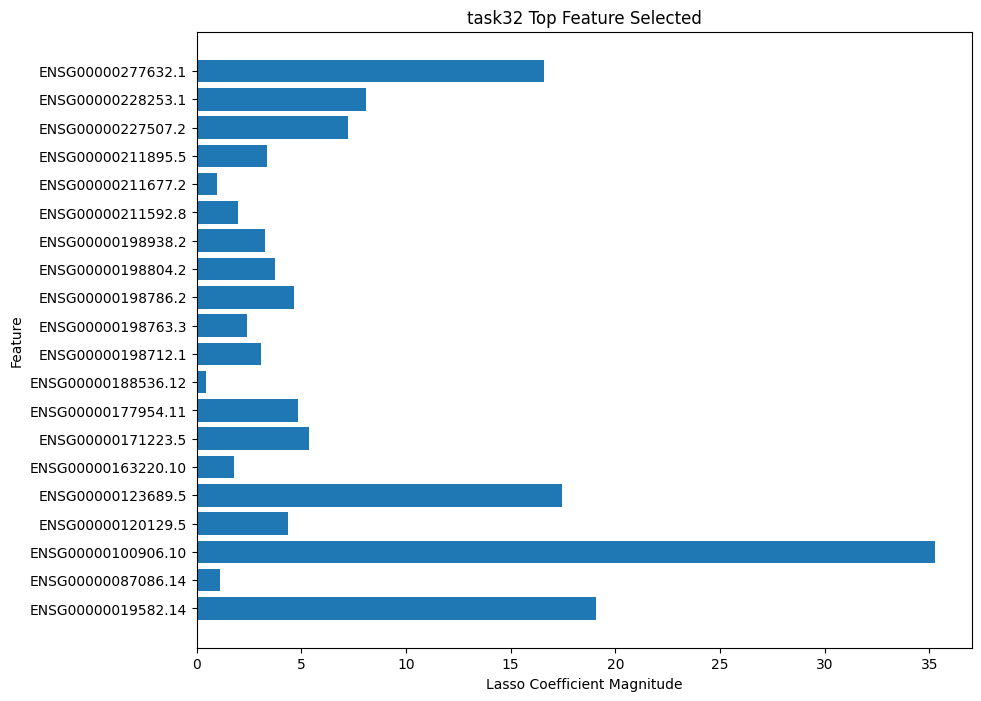

Saved model evaluation metrics to CSV.


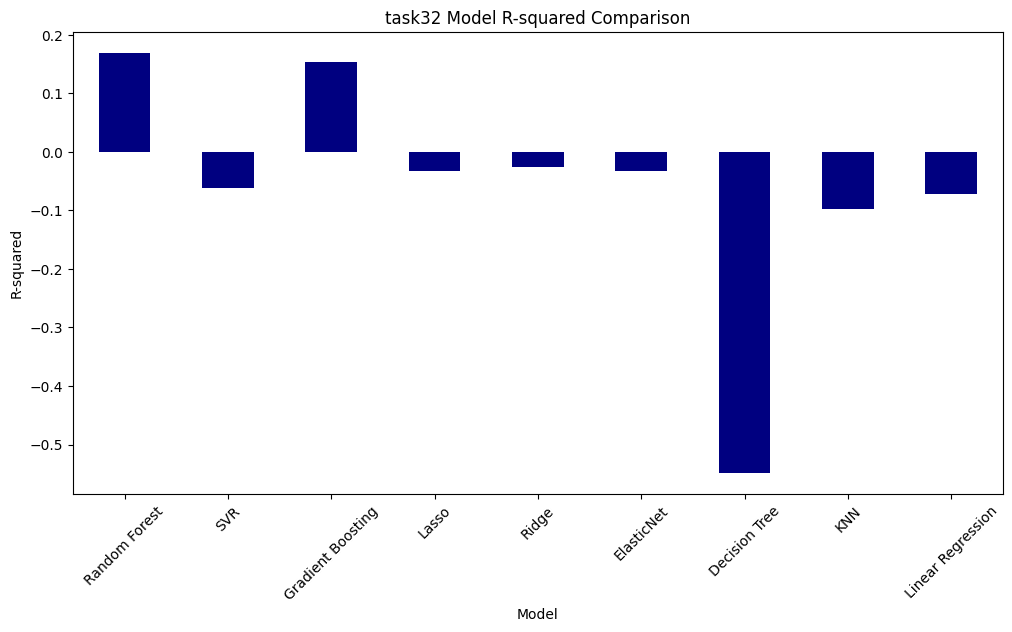

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.624177  1.012026   0.168942            0.198621
SVR                2.073823  1.158339  -0.061133           -0.047892
Gradient Boosting  1.655497  1.031416   0.152917            0.219427
Lasso              2.018517  1.130691  -0.032834            0.000000
Ridge              2.003956  1.125196  -0.025383            0.006577
ElasticNet         2.018517  1.130691  -0.032834            0.000000
Decision Tree      3.026177  1.403795  -0.548432           -0.548298
KNN                2.145887  1.172270  -0.098006           -0.064341
Linear Regression  2.093956  1.026875  -0.071434           -0.067424
Best model (Random Forest) saved.


In [28]:
train_best_model(df_train_task32.fillna(0.0), 'task32')

Best scaler: Normalizer


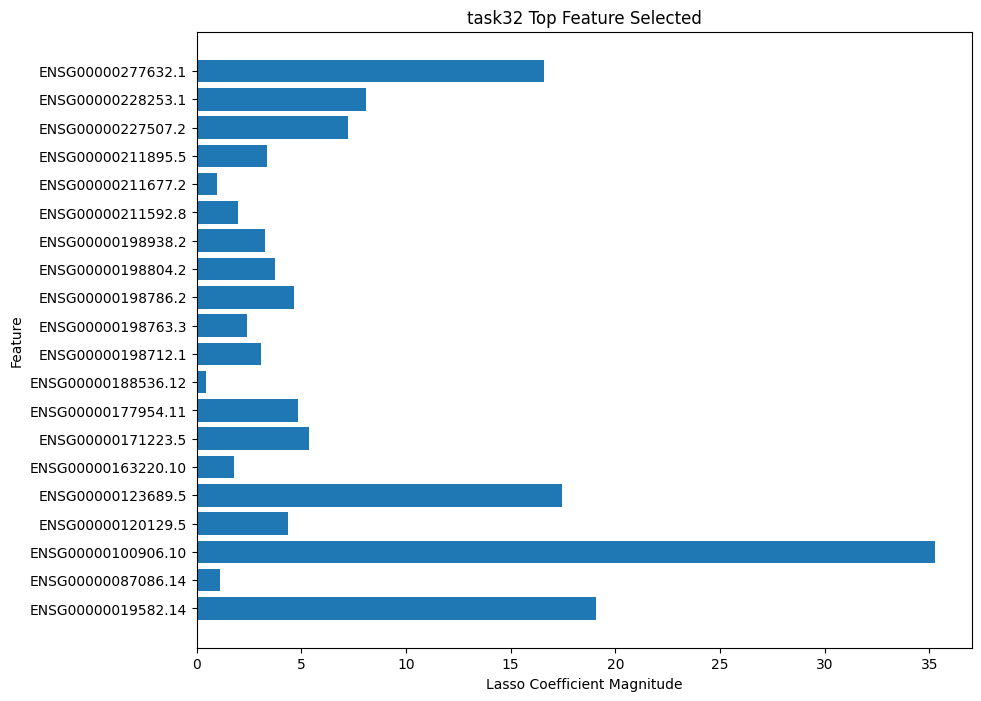

Saved model evaluation metrics to CSV.


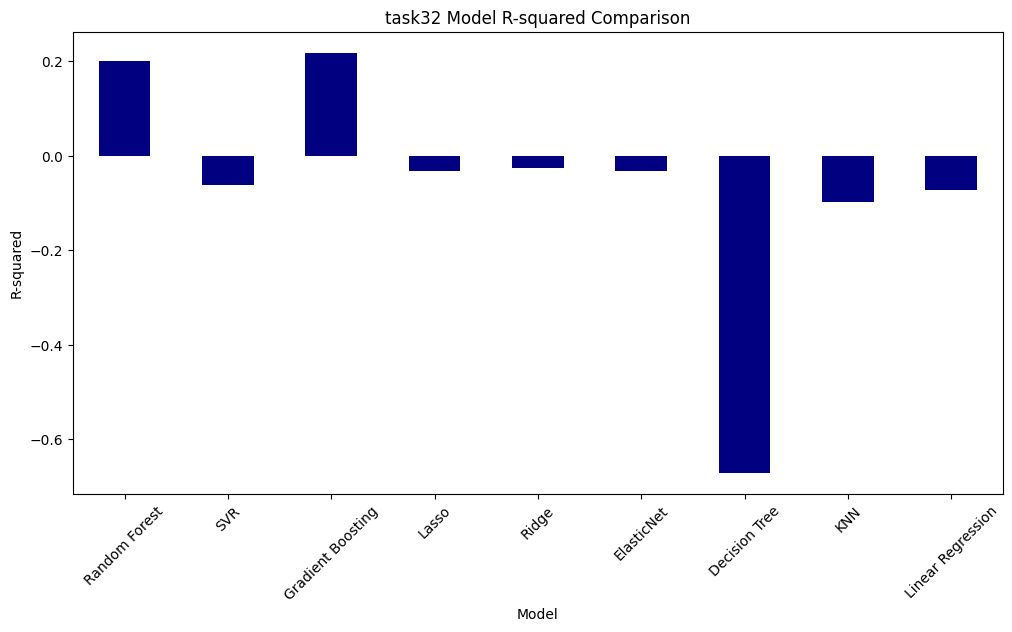

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.561084  0.966347   0.201225            0.251217
SVR                2.073823  1.158339  -0.061133           -0.047892
Gradient Boosting  1.528819  0.988097   0.217735            0.263755
Lasso              2.018517  1.130691  -0.032834            0.000000
Ridge              2.003956  1.125196  -0.025383            0.006577
ElasticNet         2.018517  1.130691  -0.032834            0.000000
Decision Tree      3.266188  1.485895  -0.671241           -0.547524
KNN                2.145887  1.172270  -0.098006           -0.064341
Linear Regression  2.093956  1.026875  -0.071434           -0.067424
Best model (Gradient Boosting) saved.


In [29]:
train_best_model(df_train_task32.fillna(1.0), 'task32')

Best scaler: Normalizer


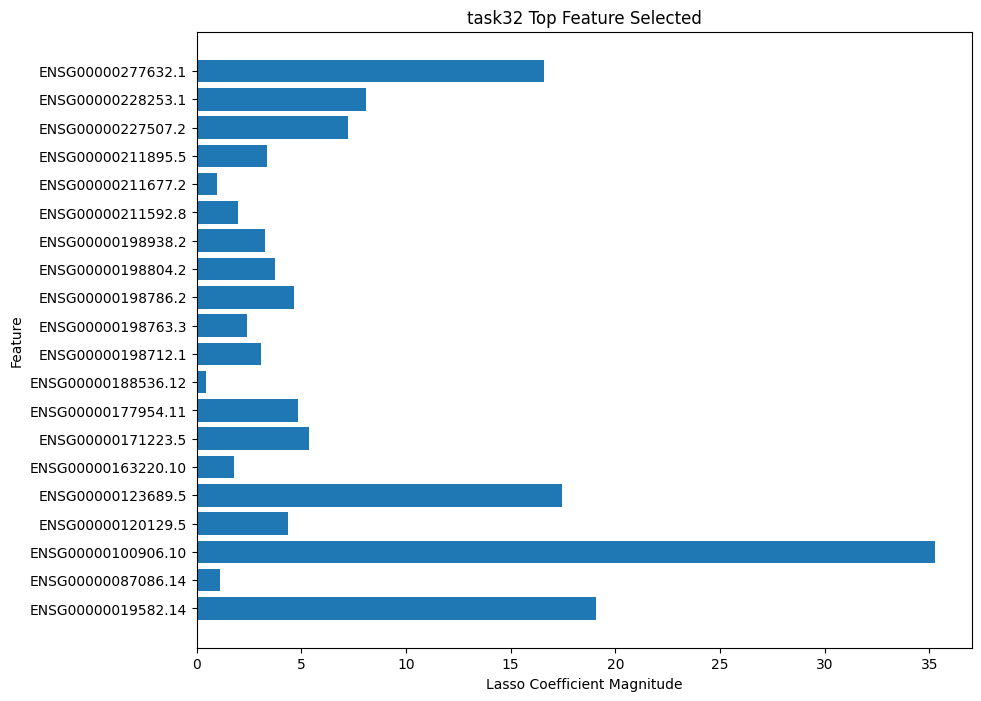

Saved model evaluation metrics to CSV.


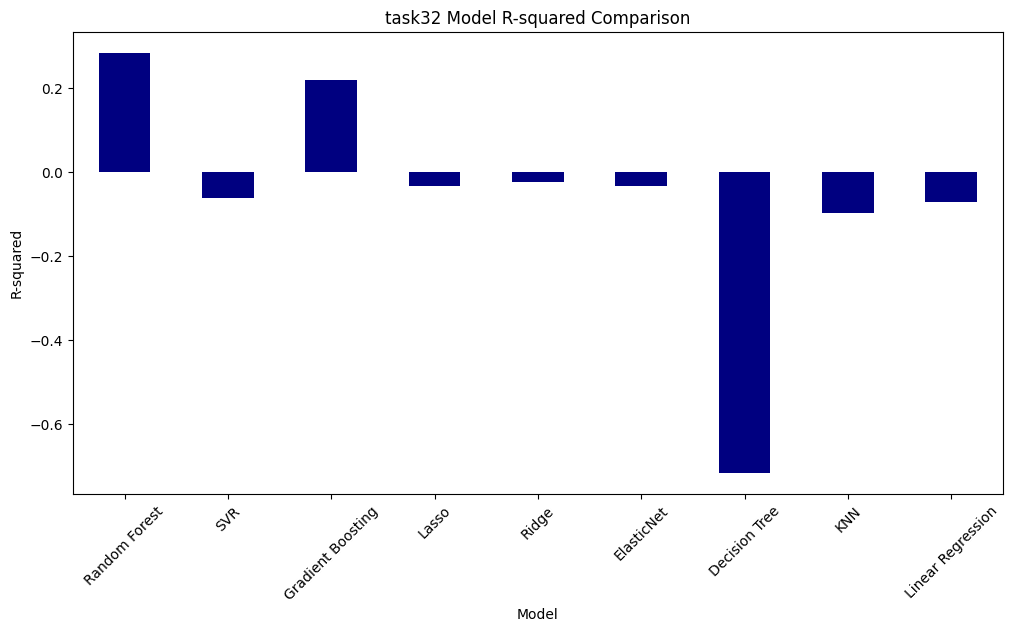

                        MSE       MAE  R-squared  Explained Variance
Model                                                               
Random Forest      1.400690  0.955558   0.283296            0.309655
SVR                2.073827  1.158340  -0.061134           -0.047893
Gradient Boosting  1.524974  0.983369   0.219702            0.264578
Lasso              2.018517  1.130691  -0.032834            0.000000
Ridge              2.003956  1.125196  -0.025383            0.006577
ElasticNet         2.018517  1.130691  -0.032834            0.000000
Decision Tree      3.355874  1.525306  -0.717132           -0.612452
KNN                2.145887  1.172270  -0.098006           -0.064341
Linear Regression  2.094008  1.026886  -0.071461           -0.067450
Best model (Random Forest) saved.


In [30]:
train_best_model(df_train_task32.fillna(df_train_task32.median()), "task32")